# Importing libraries and classes

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams


from nam.data import load_gallup_data, load_housing_data, load_sklearn_housing_data, load_breast_data

# Define the experiments configurations

In [3]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.5, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.0, fold_num=1, hidden_sizes=[], l2_regularization=0.0, logdir='output', lr=0.01, num_basis_functions=1000, num_epochs=10, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.0, regression=False, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


# Data

NAM Library contains two types of Data Classes
- **NAMDataset**: spliting the data info train, val, test
- **FoldedDataset(NAMDataset)**: performing cross validation on the dataset with multiple folds

Also, there are some predefined loading functions stores in `nam/data/datasets.py` and user can define their loading function there 

In [4]:
# dataset = load_gallup_data(config, 
#                            data_path='data/GALLUP.csv', 
#                            features_columns= ["income_2", "WP1219", "WP1220"])

dataset = load_sklearn_housing_data(config)

# dataset = load_breast_data(config)

In [5]:
dataset[0]

(tensor([ 0.0793,  0.5686, -0.9130, -0.9591, -0.9821, -0.9970,  0.1350, -0.5777]),
 tensor([4.5260]))

### Getting the training dataloaders

In [6]:
dataloaders = dataset.train_dataloaders()

## Define NAM Model

In [7]:
model = NAM(
  config=config,
  name="NAM_GALLUP",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model

/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (dropout): Dropout(p=0.5, inplace=False)
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (dropout): Dropout(p=0.5, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (dropout): Dropout(p=0.5, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=104)
        (1): Linear(in_features=104, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (dropout): Dropout(p=0.5, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
    (3): FeatureNN(
      (dropout): Dropout(p=0.5, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
    (4): FeatureNN(
      (dr

## Training loop

In [17]:
for fold, (trainloader, valloader) in enumerate(dataloaders):

    tb_logger = TensorBoardLogger(save_dir=config.logdir,
                                name=f'{model.name}',
                                version=f'fold_{fold + 1}')

    checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                        "/{epoch:02d}-{val_loss:.4f}",
                                        monitor='val_loss',
                                        save_top_k=config.save_top_k,
                                        mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(logger=tb_logger,
                       max_epochs=config.num_epochs,)
                    #    checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel,
              train_dataloader=trainloader,
              val_dataloaders=valloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 486 K 
-------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n

Epoch 9: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s, loss=828, v_num=ld_1, train_loss_step=824.0, MAE_metric_step=1.040, val_loss_step=822.0, val_loss_epoch=821.0, MAE_metric_epoch=1.010, train_loss_epoch=834.0]


### Testing the trained model

In [18]:
trainer.test(test_dataloaders=dataset.test_dataloaders())

/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE_metric': 1.077915906906128,
 'MAE_metric_epoch': 1.077915906906128,
 'test_loss': 821.72119140625,
 'test_loss_epoch': 821.72119140625}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 5/5 [00:00<00:00, 49.29it/s]


[{'test_loss': 821.72119140625,
  'test_loss_epoch': 821.72119140625,
  'MAE_metric': 1.077915906906128,
  'MAE_metric_epoch': 1.077915906906128}]

# Nam Visualization

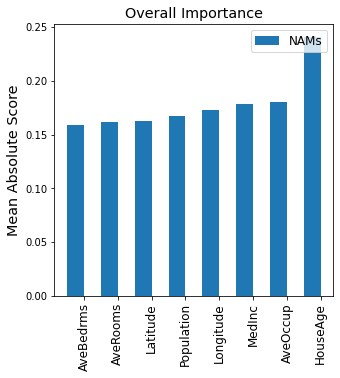

In [19]:
fig = plot_mean_feature_importance(litmodel.model, dataset)

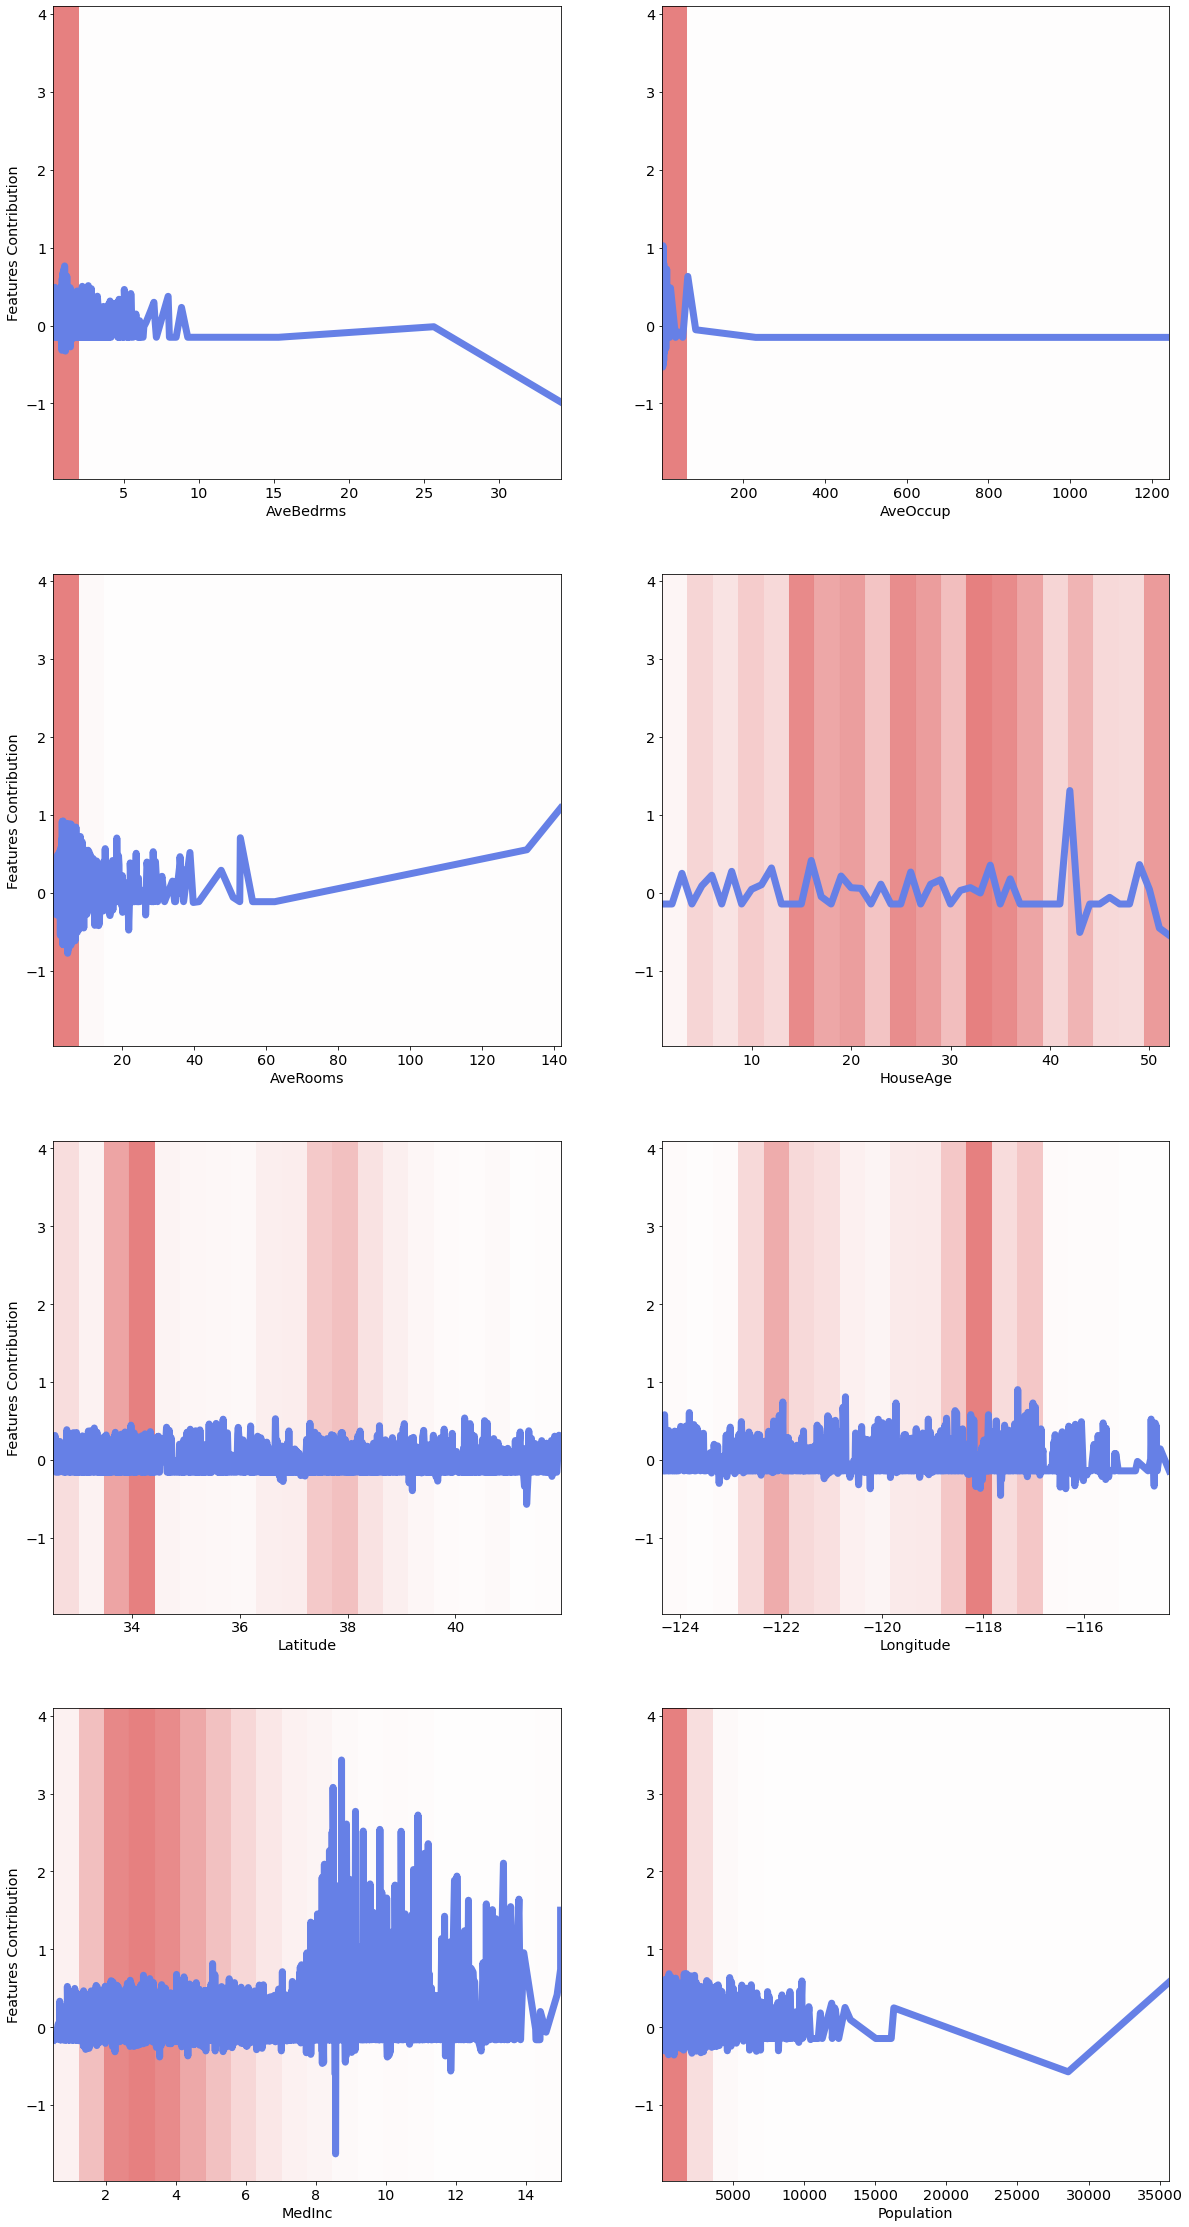

In [21]:
fig = plot_nams(litmodel.model, dataset, num_cols= 2)

In [41]:
import csv
import numpy as np
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

np.random.seed(0)

bs = 2  #This is the square root of the number of betas. Square root for plotting convenience
obs = 10000  #Number of obs
const = 5  #Constant a in y=a+beta*x+e
badd = 1  #Multiplies the normally distributed random betas by a constant
eadd = 1.7

#Creating the real underlying data
x = np.random.normal(size=[obs, bs**2])
errors = eadd * np.random.normal(size=[obs])
beta = badd * np.random.normal(size=[bs**2])
y = (const + np.matmul(np.sin(5 * x), beta) + errors)


In [42]:
x1 = pd.DataFrame(x, columns=["x1", "x2", "x3", "x4"])
y1 = pd.DataFrame(y, columns=["y"])
frames = [x1, y1]
result = pd.concat(frames, axis=1)
result

,x1,x2,x3,x4,y
0,1.764052,0.400157,0.978738,2.240893,5.461707
1,1.867558,-0.977278,0.950088,-0.151357,9.963605
2,-0.103219,0.410599,0.144044,1.454274,7.278579
3,0.761038,0.121675,0.443863,0.333674,2.663805
4,1.494079,-0.205158,0.313068,-0.854096,0.057269
...,...,...,...,...,...
9995,-0.195565,-0.649193,0.219301,-0.469272,6.498254
9996,-2.220420,-0.363021,0.214139,1.026938,-0.385739
9997,0.745472,0.347939,-0.259534,-0.000423,7.774158
9998,-0.584336,1.006808,0.592039,-1.457199,4.577456


In [43]:
config = defaults()
config.num_epochs = 3
config.regression = True
print(config)

Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.1, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.1, fold_num=1, hidden_sizes=[], l2_regularization=0.1, logdir='output', lr=0.01, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.1, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


In [44]:
dataset = NAMDataset(config, data_path=result, features_columns=result.columns[:-1], targets_column=result.columns[-1])

## Getting the training dataloaders
dataloaders = dataset.train_dataloaders()

In [45]:
model = NAM(
  config=config,
  name="NAM_SIM",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
# model

/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [46]:
from nam.trainer import Trainer

trainer = Trainer(config, model, dataset)

In [47]:
trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

2021-09-14 20:03:29,490	WARNING session.py:29 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2021-09-14 20:03:29,490	WARNING session.py:33 --   File "/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/tornado/platform

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

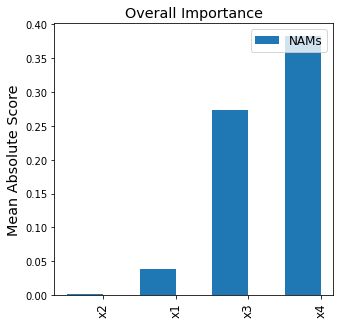

In [48]:
fig1 = plot_mean_feature_importance(trainer.model, dataset)

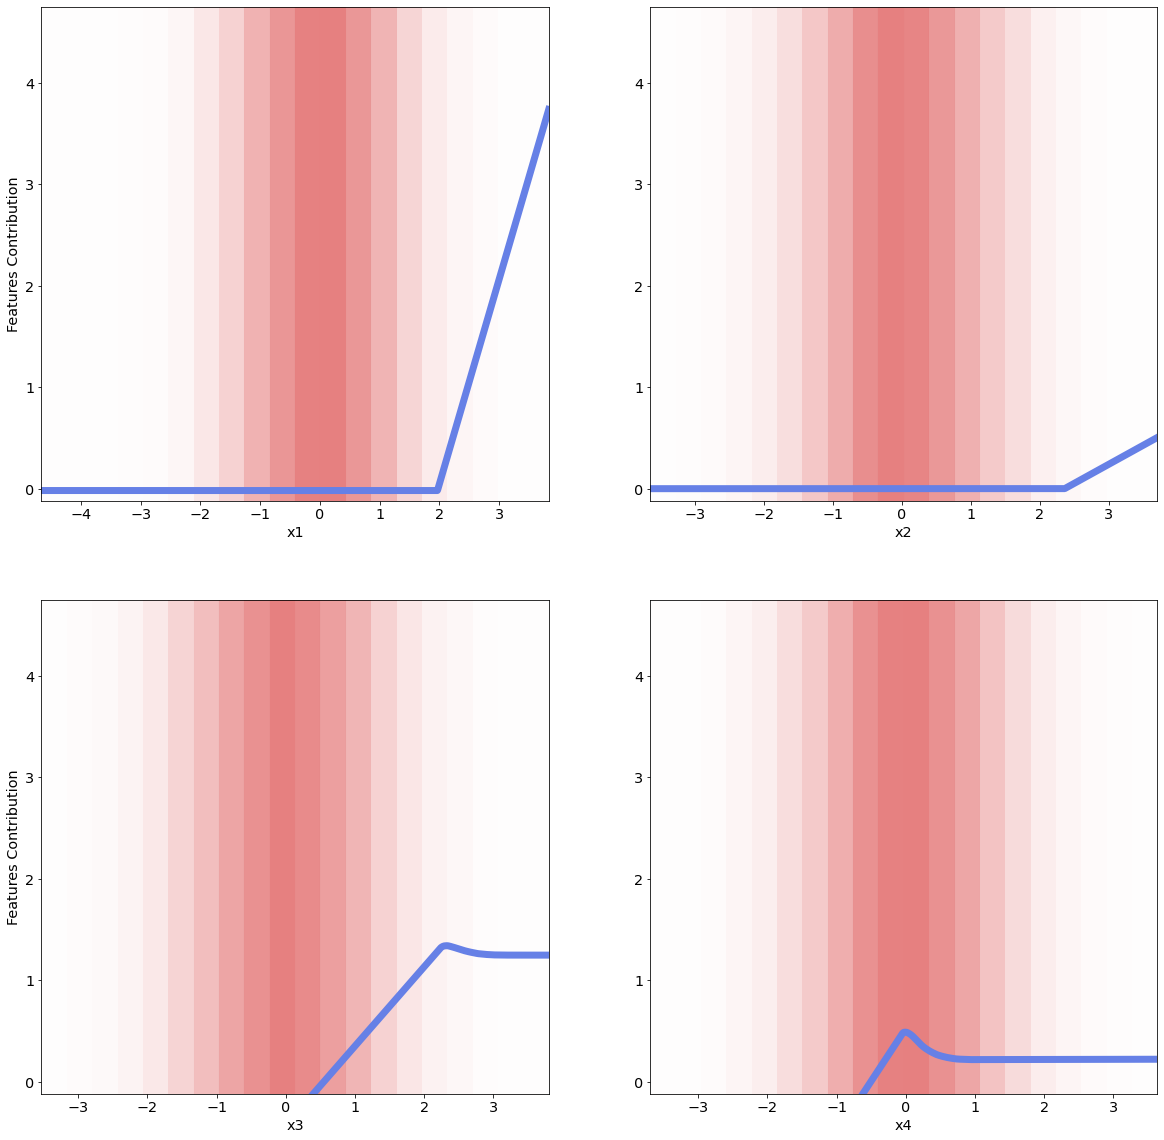

In [49]:
fig2 = plot_nams(trainer.model, dataset, num_cols= 2)


In [144]:
x1.describe()

,x1,x2,x3,x4
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.003559,-0.004187,-0.011821,0.004453
std,0.993948,0.992632,1.005389,0.995020
min,-4.659953,-3.643294,-3.532992,-3.694285
25%,-0.683687,-0.657166,-0.684110,-0.656669
50%,0.000371,-0.006782,-0.013269,0.005918
75%,0.665680,0.656786,0.671501,0.671408
max,3.831790,3.702938,3.801660,3.636102


In [18]:
config = defaults()
config.num_epochs = 3
config.regression = True

def best_hparams(cfg):
    config.update(**cfg)
    print(config)
    dataset = NAMDataset(config=config,
                         data_path=result,
                         features_columns=result.columns[:-1],
                         targets_column=result.columns[-1])

    model = NAM(
        config=config,
        name="NAM_SIM",
        num_inputs=len(dataset[0][0]),
        num_units=get_num_units(config, dataset.features),
    )

    trainer = Trainer(config, model, dataset)
    trainer.train()


In [50]:
from ray import tune

analysis = tune.run(best_hparams,
                    num_samples=25,
                    metric="loss",
                    mode="min",
                    config={
                        "lr": tune.loguniform(1e-4, 1e-1),
                        "l2_regularization": tune.loguniform(0.01, 1.0),
                        "output_regularization": tune.loguniform(0.01, 1.0),
                        "dropout": tune.loguniform(0.01, 1.0),
                        "feature_dropout": tune.loguniform(0.01, 1.0),
                        "batch_size": tune.choice([128, 512, 1024]),
                        "hidden_sizes": tune.choice([[], [32], [64, 32]])
                    })


/home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/ray/tune/sample.py:297: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.random.choice(domain.categories, size=size).tolist()


Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization
best_hparams_c4bf2_00000,PENDING,,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441
best_hparams_c4bf2_00001,PENDING,,512,0.1434,0.01745,[32],0.135229,0.00689577,0.137988
best_hparams_c4bf2_00002,PENDING,,1024,0.179234,0.123884,[],0.128073,0.0253471,0.202389
best_hparams_c4bf2_00003,PENDING,,128,0.0179452,0.200293,[],0.983899,0.00455741,0.328659
best_hparams_c4bf2_00004,PENDING,,1024,0.490315,0.0527209,[32],0.0207292,0.00243823,0.0242854
best_hparams_c4bf2_00005,PENDING,,512,0.211543,0.0731834,[],0.039097,0.000318905,0.055128
best_hparams_c4bf2_00006,PENDING,,128,0.0299852,0.0397608,[32],0.0343092,0.000957107,0.0146538
best_hparams_c4bf2_00007,PENDING,,128,0.817456,0.218654,[32],0.239223,0.0112604,0.259055
best_hparams_c4bf2_00008,PENDING,,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762
best_hparams_c4bf2_00009,PENDING,,512,0.088527,0.521383,"[64, 32]",0.0427778,0.000419824,0.654098


(pid=15214) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.056160328127543784, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.9406477643746788, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.040509503868713034, logdir='output', lr=0.09778098177776211, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.07904407990271264, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)
(pid=15215) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.017945182806915264, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.20029271727723505, fold_num=1, hidden_sizes=[], l2_regularization=0.9838993288638642, logdir='output', lr=0.004557406175619429, num_basis

(pid=15214) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15214)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15215) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15215)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/57 [00:00<?, ?it/s]
(pid=15221) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15221)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15217) /home/amrmka

(pid=15216) Config(activation='exu', batch_size=512, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.21154308783240286, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.0731834023919291, fold_num=1, hidden_sizes=[], l2_regularization=0.03909695996786522, logdir='output', lr=0.00031890482793038653, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.05512795067691777, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)
(pid=15232) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.8174557025447711, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.21865355461660363, fold_num=1, hidden_sizes=[32], l2_regularization=0.23922291270209156, logdir='output', lr=0.011260415264356862, num_basis_func

(pid=15215) 
TL Step: 3520.466 | MAE: 4.659:   4%|▎         | 2/57 [00:00<00:03, 16.56it/s]
TL Step: 3480.134 | MAE: 2.351:   4%|▎         | 2/57 [00:00<00:03, 16.56it/s]
TL Step: 3462.426 | MAE: 2.514:   4%|▎         | 2/57 [00:00<00:03, 16.56it/s]
TL Step: 3456.188 | MAE: 3.953:   4%|▎         | 2/57 [00:00<00:03, 16.56it/s]
TL Step: 3456.188 | MAE: 3.953:  11%|█         | 6/57 [00:00<00:01, 26.16it/s]
(pid=15217) 
TL Step: 622.396 | MAE: 8.088:   7%|▋         | 1/15 [00:00<00:02,  6.04it/s]
TL Step: 622.396 | MAE: 8.088:  13%|█▎        | 2/15 [00:00<00:01,  7.09it/s]
(pid=15232) 
TL Step: 1534.810 | MAE: 11.248:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 2214.520 | MAE: 11.997:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 2214.520 | MAE: 11.997:   4%|▎         | 2/57 [00:00<00:03, 18.15it/s]
(pid=15216) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribut

(pid=15218) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.029985151447911588, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.03976081592436619, fold_num=1, hidden_sizes=[32], l2_regularization=0.03430922745755593, logdir='output', lr=0.0009571073173507209, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.014653788498923669, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15215) 
TL Step: 3384.031 | MAE: 2.705:  16%|█▌        | 9/57 [00:00<00:01, 26.36it/s]
(pid=15232) 
TL Step: 2498.118 | MAE: 14.677:   7%|▋         | 4/57 [00:00<00:02, 18.04it/s]
TL Step: 2242.840 | MAE: 14.264:   7%|▋         | 4/57 [00:00<00:02, 18.04it/s]
(pid=15216) 
TL Step: 184.907 | MAE: 6.239:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 184.907 | MAE: 6.239:   7%|▋         | 1/15 [00:00<00:01,  7.07it/s]
(pid=15218) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15218)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 163.528 | MAE: 4.952:   0%|          | 0/57 [00:00<?, ?it/s]
(pid=15215) 
TL Step: 3371.145 | MAE: 3.181:  16%|█▌        | 9/57 [00:00<00:01, 26.36it/s]


Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization
best_hparams_c4bf2_00000,RUNNING,,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441
best_hparams_c4bf2_00001,RUNNING,,512,0.1434,0.01745,[32],0.135229,0.00689577,0.137988
best_hparams_c4bf2_00002,RUNNING,,1024,0.179234,0.123884,[],0.128073,0.0253471,0.202389
best_hparams_c4bf2_00003,RUNNING,,128,0.0179452,0.200293,[],0.983899,0.00455741,0.328659
best_hparams_c4bf2_00004,RUNNING,,1024,0.490315,0.0527209,[32],0.0207292,0.00243823,0.0242854
best_hparams_c4bf2_00005,RUNNING,,512,0.211543,0.0731834,[],0.039097,0.000318905,0.055128
best_hparams_c4bf2_00006,RUNNING,,128,0.0299852,0.0397608,[32],0.0343092,0.000957107,0.0146538
best_hparams_c4bf2_00007,RUNNING,,128,0.817456,0.218654,[32],0.239223,0.0112604,0.259055
best_hparams_c4bf2_00008,PENDING,,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762
best_hparams_c4bf2_00009,PENDING,,512,0.088527,0.521383,"[64, 32]",0.0427778,0.000419824,0.654098


(pid=15215) 
TL Step: 3353.861 | MAE: 3.135:  16%|█▌        | 9/57 [00:00<00:01, 26.36it/s]
TL Step: 3353.861 | MAE: 3.135:  21%|██        | 12/57 [00:00<00:01, 24.00it/s]
TL Step: 3330.529 | MAE: 2.323:  21%|██        | 12/57 [00:00<00:01, 24.00it/s]
TL Step: 3313.091 | MAE: 2.293:  21%|██        | 12/57 [00:00<00:01, 24.00it/s]
(pid=15217) 
TL Step: 538.978 | MAE: 3.733:  13%|█▎        | 2/15 [00:00<00:01,  7.09it/s]
TL Step: 538.978 | MAE: 3.733:  20%|██        | 3/15 [00:00<00:02,  4.72it/s]
(pid=15232) 
TL Step: 1112.975 | MAE: 7.293:   7%|▋         | 4/57 [00:00<00:02, 18.04it/s] 
TL Step: 1112.975 | MAE: 7.293:  12%|█▏        | 7/57 [00:00<00:02, 19.52it/s]
TL Step: 3437.420 | MAE: 14.360:  12%|█▏        | 7/57 [00:00<00:02, 19.52it/s]
(pid=15216) 
TL Step: 176.917 | MAE: 5.621:   7%|▋         | 1/15 [00:00<00:01,  7.07it/s]
TL Step: 176.917 | MAE: 5.621:  13%|█▎        | 2/15 [00:00<00:01,  7.41it/s]
(pid=15218) 
TL Step: 140.240 | MAE: 2.126:   0%|          | 0/57 [00:00<?, ?i

Result for best_hparams_c4bf2_00001:
  date: 2021-09-14_20-10-19
  done: false
  experiment_id: cc990fbdc4f2493982d2d5a5e9ba13af
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(467.3788)
  node_ip: 10.164.0.6
  pid: 15217
  time_since_restore: 2.5646603107452393
  time_this_iter_s: 2.5646603107452393
  time_total_s: 2.5646603107452393
  timestamp: 1631650219
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00001
  
Result for best_hparams_c4bf2_00002:
  date: 2021-09-14_20-10-19
  done: false
  experiment_id: 7ea597141d04485f8665f8619a4a548f
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(416.8544)
  node_ip: 10.164.0.6
  pid: 15221
  time_since_restore: 2.5670390129089355
  time_this_iter_s: 2.5670390129089355
  time_total_s: 2.5670390129089355
  timestamp: 1631650219
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00002
  
Result for best_hparams_c4bf2_00005:
  date: 2021-09-14_20-10-19
  done: false
  exper

(pid=15215) 
TL Step: 2686.577 | MAE: 2.023:  93%|█████████▎| 53/57 [00:02<00:00, 23.60it/s]
TL Step: 2673.803 | MAE: 2.329:  93%|█████████▎| 53/57 [00:02<00:00, 23.60it/s]
TL Step: 2673.803 | MAE: 2.329:  98%|█████████▊| 56/57 [00:02<00:00, 21.44it/s]
TL Step: 2658.875 | MAE: 2.082:  98%|█████████▊| 56/57 [00:02<00:00, 21.44it/s]
                                                                               
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 2644.251 | MAE: 1.962:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 2645.958 | MAE: 2.253:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 2644.666 | MAE: 2.180:   0%|          | 0/7 [00:00<?, ?it/s]
Epoch(0):
(pid=15221)             TL: 627.941 |
(pid=15221)             VL: 416.854 |
Epoch(0):
(pid=15221)             TL: 627.941 |
(pid=15221)             VL: 416.854 |
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15232) 
TL Step: 576.712 | MAE: 4.267:  75%|███████▌  | 43/57 [00:02<00:00, 18.17it/s]
TL Step: 568.625 | MAE: 4.079:  75%|█

Result for best_hparams_c4bf2_00004:
  date: 2021-09-14_20-10-20
  done: false
  experiment_id: aa69509e8e1a42b6bf877b1382e5627e
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(99.5927)
  node_ip: 10.164.0.6
  pid: 15220
  time_since_restore: 2.6432814598083496
  time_this_iter_s: 2.6432814598083496
  time_total_s: 2.6432814598083496
  timestamp: 1631650220
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00004
  
Result for best_hparams_c4bf2_00000:
  date: 2021-09-14_20-10-20
  done: false
  experiment_id: 8ae4e1e3eacf4de8982baae88d49145c
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(861.0186)
  node_ip: 10.164.0.6
  pid: 15214
  time_since_restore: 3.0892927646636963
  time_this_iter_s: 3.0892927646636963
  time_total_s: 3.0892927646636963
  timestamp: 1631650220
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00000
  


(pid=15214) 
VL Step: 861.019 | MAE: 20.996:   0%|          | 0/1 [00:00<?, ?it/s]
Epoch(0):
(pid=15214)             TL: 206028.078 |
(pid=15214)             VL: 861.019 |
Epoch(0):
(pid=15214)             TL: 206028.078 |
(pid=15214)             VL: 861.019 |
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15215) 
TL Step: 2574.785 | MAE: 1.961:   9%|▉         | 5/57 [00:00<00:02, 22.62it/s]
TL Step: 2563.250 | MAE: 2.295:   9%|▉         | 5/57 [00:00<00:02, 22.62it/s]
(pid=15217) 
TL Step: 460.077 | MAE: 2.226:  13%|█▎        | 2/15 [00:00<00:01,  6.78it/s]
TL Step: 460.077 | MAE: 2.226:  20%|██        | 3/15 [00:00<00:01,  6.47it/s]
(pid=15232) 
TL Step: 518.160 | MAE: 4.015:  89%|████████▉ | 51/57 [00:02<00:00, 18.46it/s]
TL Step: 514.709 | MAE: 4.467:  89%|████████▉ | 51/57 [00:02<00:00, 18.46it/s]
TL Step: 514.709 | MAE: 4.467:  93%|█████████▎| 53/57 [00:02<00:00, 18.68it/s]
(pid=15218) 
TL Step: 132.183 | MAE: 2.107:  77%|███████▋  | 44/57 [00:02<00:00, 17.29it/s]
TL Step: 131.373 | 

Result for best_hparams_c4bf2_00007:
  date: 2021-09-14_20-10-20
  done: false
  experiment_id: f3b6904964d44d8b85ca5765c5495d3e
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(478.1667)
  node_ip: 10.164.0.6
  pid: 15232
  time_since_restore: 3.2454278469085693
  time_this_iter_s: 3.2454278469085693
  time_total_s: 3.2454278469085693
  timestamp: 1631650220
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00007
  


(pid=15215) 
TL Step: 2441.340 | MAE: 2.001:  25%|██▍       | 14/57 [00:00<00:02, 20.91it/s]
TL Step: 2428.285 | MAE: 1.949:  25%|██▍       | 14/57 [00:00<00:02, 20.91it/s]
TL Step: 2428.285 | MAE: 1.949:  30%|██▉       | 17/57 [00:00<00:01, 22.29it/s]
(pid=15232) 
TL Step: 471.805 | MAE: 4.136:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 471.805 | MAE: 4.136:   4%|▎         | 2/57 [00:00<00:03, 13.88it/s]
TL Step: 467.365 | MAE: 4.309:   4%|▎         | 2/57 [00:00<00:03, 13.88it/s]
(pid=15216) 
TL Step: 155.570 | MAE: 3.284:  33%|███▎      | 5/15 [00:00<00:01,  6.95it/s]
TL Step: 155.570 | MAE: 3.284:  40%|████      | 6/15 [00:00<00:01,  6.68it/s]
(pid=15220) 
TL Step: 98.400 | MAE: 3.780:  12%|█▎        | 1/8 [00:00<00:02,  3.42it/s]
TL Step: 98.400 | MAE: 3.780:  25%|██▌       | 2/8 [00:00<00:01,  3.16it/s]
(pid=15218) 
TL Step: 129.329 | MAE: 1.756:  84%|████████▍ | 48/57 [00:02<00:00, 15.98it/s]
TL Step: 129.329 | MAE: 1.756:  88%|████████▊ | 50/57 [00:02<00:00, 12.71it/s]
TL 

Result for best_hparams_c4bf2_00006:
  date: 2021-09-14_20-10-21
  done: false
  experiment_id: 9c7fc24052434335b78ce2694b1c27af
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(129.8222)
  node_ip: 10.164.0.6
  pid: 15218
  time_since_restore: 3.6290342807769775
  time_this_iter_s: 3.6290342807769775
  time_total_s: 3.6290342807769775
  timestamp: 1631650221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00006
  


(pid=15215) 
TL Step: 2275.260 | MAE: 1.970:  46%|████▌     | 26/57 [00:01<00:01, 21.49it/s]
TL Step: 2275.260 | MAE: 1.970:  51%|█████     | 29/57 [00:01<00:01, 23.08it/s]
TL Step: 2263.561 | MAE: 2.151:  51%|█████     | 29/57 [00:01<00:01, 23.08it/s]
TL Step: 2250.786 | MAE: 2.057:  51%|█████     | 29/57 [00:01<00:01, 23.08it/s]
(pid=15221) 
TL Step: 364.938 | MAE: 5.298:  50%|█████     | 4/8 [00:01<00:01,  3.14it/s]
TL Step: 364.938 | MAE: 5.298:  62%|██████▎   | 5/8 [00:01<00:00,  3.41it/s]
(pid=15217) 
TL Step: 436.997 | MAE: 2.234:  53%|█████▎    | 8/15 [00:01<00:01,  5.80it/s]
TL Step: 436.997 | MAE: 2.234:  60%|██████    | 9/15 [00:01<00:00,  6.18it/s]
(pid=15232) 
TL Step: 417.309 | MAE: 4.125:  16%|█▌        | 9/57 [00:00<00:03, 14.96it/s]
TL Step: 417.309 | MAE: 4.125:  19%|█▉        | 11/57 [00:00<00:02, 16.12it/s]
TL Step: 411.889 | MAE: 4.116:  19%|█▉        | 11/57 [00:00<00:02, 16.12it/s]
(pid=15216) 
TL Step: 156.597 | MAE: 3.463:  60%|██████    | 9/15 [00:01<00:00,  6

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00000,RUNNING,10.164.0.6:15214,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441,1,3.08929
best_hparams_c4bf2_00001,RUNNING,10.164.0.6:15217,512,0.1434,0.01745,[32],0.135229,0.00689577,0.137988,2,5.09479
best_hparams_c4bf2_00002,RUNNING,10.164.0.6:15221,1024,0.179234,0.123884,[],0.128073,0.0253471,0.202389,2,4.77991
best_hparams_c4bf2_00003,RUNNING,10.164.0.6:15215,128,0.0179452,0.200293,[],0.983899,0.00455741,0.328659,2,5.28506
best_hparams_c4bf2_00004,RUNNING,10.164.0.6:15220,1024,0.490315,0.0527209,[32],0.0207292,0.00243823,0.0242854,2,5.14838
best_hparams_c4bf2_00005,RUNNING,10.164.0.6:15216,512,0.211543,0.0731834,[],0.039097,0.000318905,0.055128,2,4.73324
best_hparams_c4bf2_00006,RUNNING,10.164.0.6:15218,128,0.0299852,0.0397608,[32],0.0343092,0.000957107,0.0146538,1,3.62903
best_hparams_c4bf2_00007,RUNNING,10.164.0.6:15232,128,0.817456,0.218654,[32],0.239223,0.0112604,0.259055,1,3.24543
best_hparams_c4bf2_00008,PENDING,,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762,,
best_hparams_c4bf2_00009,PENDING,,512,0.088527,0.521383,"[64, 32]",0.0427778,0.000419824,0.654098,,


(pid=15215) 
TL Step: 1840.847 | MAE: 2.183:  16%|█▌        | 9/57 [00:00<00:02, 23.68it/s]
TL Step: 1830.836 | MAE: 2.175:  16%|█▌        | 9/57 [00:00<00:02, 23.68it/s]
TL Step: 1819.058 | MAE: 2.015:  16%|█▌        | 9/57 [00:00<00:02, 23.68it/s]
TL Step: 1819.058 | MAE: 2.015:  21%|██        | 12/57 [00:00<00:01, 25.30it/s]
(pid=15221) 
TL Step: 318.130 | MAE: 6.239:  25%|██▌       | 2/8 [00:00<00:01,  3.19it/s]
TL Step: 318.130 | MAE: 6.239:  38%|███▊      | 3/8 [00:00<00:01,  3.45it/s]
(pid=15232) 
TL Step: 261.209 | MAE: 3.921:  74%|███████▎  | 42/57 [00:02<00:00, 20.80it/s]
TL Step: 257.795 | MAE: 4.136:  74%|███████▎  | 42/57 [00:02<00:00, 20.80it/s]
TL Step: 257.795 | MAE: 4.136:  79%|███████▉  | 45/57 [00:02<00:00, 20.60it/s]
(pid=15216) 
TL Step: 154.933 | MAE: 3.303:  40%|████      | 6/15 [00:00<00:01,  8.53it/s]
TL Step: 154.933 | MAE: 3.303:  47%|████▋     | 7/15 [00:00<00:01,  7.01it/s]
(pid=15220) 
TL Step: 94.782 | MAE: 3.515:   0%|          | 0/8 [00:00<?, ?it/s]
TL 

Result for best_hparams_c4bf2_00005:
  date: 2021-09-14_20-10-24
  done: true
  experiment_id: 961227623d374e11a3f107269d702e06
  experiment_tag: 5_batch_size=512,dropout=0.21154,feature_dropout=0.073183,hidden_sizes=[],l2_regularization=0.039097,lr=0.0003189,output_regularization=0.055128
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(151.0495)
  node_ip: 10.164.0.6
  pid: 15216
  time_since_restore: 6.647677421569824
  time_this_iter_s: 1.914440393447876
  time_total_s: 6.647677421569824
  timestamp: 1631650224
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00005
  
Result for best_hparams_c4bf2_00002:
  date: 2021-09-14_20-10-24
  done: true
  experiment_id: 7ea597141d04485f8665f8619a4a548f
  experiment_tag: 2_batch_size=1024,dropout=0.17923,feature_dropout=0.12388,hidden_sizes=[],l2_regularization=0.12807,lr=0.025347,output_regularization=0.20239
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(240.3157)
  node_ip: 10.164.0.6


(pid=15215) 
TL Step: 1474.337 | MAE: 2.223:  81%|████████  | 46/57 [00:01<00:00, 31.00it/s]
TL Step: 1463.400 | MAE: 1.982:  81%|████████  | 46/57 [00:01<00:00, 31.00it/s]
TL Step: 1453.553 | MAE: 1.784:  81%|████████  | 46/57 [00:01<00:00, 31.00it/s]
TL Step: 1453.553 | MAE: 1.784:  88%|████████▊ | 50/57 [00:01<00:00, 32.79it/s]
TL Step: 1444.833 | MAE: 1.883:  88%|████████▊ | 50/57 [00:01<00:00, 32.79it/s]
(pid=15217) 
(pid=15232) 
TL Step: 191.451 | MAE: 3.542:   9%|▉         | 5/57 [00:00<00:02, 19.48it/s]
TL Step: 191.451 | MAE: 3.542:  12%|█▏        | 7/57 [00:00<00:02, 19.34it/s]
TL Step: 190.790 | MAE: 3.892:  12%|█▏        | 7/57 [00:00<00:02, 19.34it/s]
(pid=15218) 
TL Step: 121.328 | MAE: 1.958:  89%|████████▉ | 51/57 [00:02<00:00, 15.84it/s]
TL Step: 121.328 | MAE: 1.958:  95%|█████████▍| 54/57 [00:02<00:00, 17.14it/s]
TL Step: 120.560 | MAE: 1.733:  95%|█████████▍| 54/57 [00:03<00:00, 17.14it/s]
TL Step: 371.359 | MAE: 2.239:  80%|████████  | 12/15 [00:01<00:00,  6.95it/s

Result for best_hparams_c4bf2_00001:
  date: 2021-09-14_20-10-24
  done: true
  experiment_id: cc990fbdc4f2493982d2d5a5e9ba13af
  experiment_tag: 1_batch_size=512,dropout=0.1434,feature_dropout=0.01745,hidden_sizes=[32],l2_regularization=0.13523,lr=0.0068958,output_regularization=0.13799
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(359.8213)
  node_ip: 10.164.0.6
  pid: 15217
  time_since_restore: 7.315601110458374
  time_this_iter_s: 2.220808506011963
  time_total_s: 7.315601110458374
  timestamp: 1631650224
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00001
  
Result for best_hparams_c4bf2_00003:
  date: 2021-09-14_20-10-24
  done: true
  experiment_id: 8d1cb10e7b944e63a8056303967e759a
  experiment_tag: 3_batch_size=128,dropout=0.017945,feature_dropout=0.20029,hidden_sizes=[],l2_regularization=0.9839,lr=0.0045574,output_regularization=0.32866
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(1387.6729)
  node_ip: 10.164.0.6
 

(pid=15215) 
VL Step: 1386.795 | MAE: 2.238:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 1387.685 | MAE: 2.413:   0%|          | 0/7 [00:00<?, ?it/s]
(pid=15232) 
TL Step: 170.134 | MAE: 3.627:  23%|██▎       | 13/57 [00:00<00:01, 22.72it/s]
(pid=15215) 
VL Step: 1386.672 | MAE: 2.179:   0%|          | 0/7 [00:00<?, ?it/s]
                                                                     
Epoch(2):
(pid=15215)             TL: 1654.548 |
(pid=15215)             VL: 1387.673 |
Epoch(2):
(pid=15215)             TL: 1654.548 |
(pid=15215)             VL: 1387.673 |
Epoch(2):
(pid=15215)             TL: 1654.548 |
(pid=15215)             VL: 1387.673 |
(pid=15215)             MAE: 2.069: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]
(pid=15232) 
TL Step: 170.860 | MAE: 4.124:  23%|██▎       | 13/57 [00:00<00:01, 22.72it/s]
TL Step: 170.860 | MAE: 4.124:  28%|██▊       | 16/57 [00:00<00:01, 21.03it/s]
TL Step: 165.357 | MAE: 3.656:  28%|██▊       | 16/57 [00:00<00:01, 21.03it/s]
TL Ste

Result for best_hparams_c4bf2_00004:
  date: 2021-09-14_20-10-24
  done: true
  experiment_id: aa69509e8e1a42b6bf877b1382e5627e
  experiment_tag: 4_batch_size=1024,dropout=0.49031,feature_dropout=0.052721,hidden_sizes=[32],l2_regularization=0.020729,lr=0.0024382,output_regularization=0.024285
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(89.0943)
  node_ip: 10.164.0.6
  pid: 15220
  time_since_restore: 7.359253883361816
  time_this_iter_s: 2.2108709812164307
  time_total_s: 7.359253883361816
  timestamp: 1631650224
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00004
  


(pid=15232) 
TL Step: 155.285 | MAE: 3.901:  39%|███▊      | 22/57 [00:01<00:01, 24.17it/s]
TL Step: 147.877 | MAE: 3.875:  39%|███▊      | 22/57 [00:01<00:01, 24.17it/s]
TL Step: 147.877 | MAE: 3.875:  44%|████▍     | 25/57 [00:01<00:01, 23.55it/s]
TL Step: 141.458 | MAE: 3.336:  44%|████▍     | 25/57 [00:01<00:01, 23.55it/s]
(pid=15218) 
TL Step: 120.252 | MAE: 2.067:  16%|█▌        | 9/57 [00:00<00:02, 21.97it/s]
TL Step: 120.252 | MAE: 2.067:  21%|██        | 12/57 [00:00<00:01, 23.26it/s]
TL Step: 120.763 | MAE: 2.156:  21%|██        | 12/57 [00:00<00:01, 23.26it/s]
(pid=15214) 
TL Step: 5189.294 | MAE: 51.210:  50%|█████     | 4/8 [00:01<00:01,  2.45it/s]  
TL Step: 5189.294 | MAE: 51.210:  62%|██████▎   | 5/8 [00:01<00:01,  2.70it/s]
(pid=15232) 
TL Step: 141.842 | MAE: 3.568:  44%|████▍     | 25/57 [00:01<00:01, 23.55it/s]
(pid=15218) 
TL Step: 120.044 | MAE: 2.090:  21%|██        | 12/57 [00:00<00:01, 23.26it/s]
TL Step: 118.718 | MAE: 1.908:  21%|██        | 12/57 [00:00<00:0

Result for best_hparams_c4bf2_00000:
  date: 2021-09-14_20-10-25
  done: false
  experiment_id: 8ae4e1e3eacf4de8982baae88d49145c
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(676.7284)
  node_ip: 10.164.0.6
  pid: 15214
  time_since_restore: 8.661948204040527
  time_this_iter_s: 2.6435294151306152
  time_total_s: 8.661948204040527
  timestamp: 1631650225
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00000
  
Result for best_hparams_c4bf2_00000:
  date: 2021-09-14_20-10-25
  done: true
  experiment_id: 8ae4e1e3eacf4de8982baae88d49145c
  experiment_tag: 0_batch_size=1024,dropout=0.05616,feature_dropout=0.94065,hidden_sizes=[64,
    32],l2_regularization=0.04051,lr=0.097781,output_regularization=0.079044
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(676.7284)
  node_ip: 10.164.0.6
  pid: 15214
  time_since_restore: 8.661948204040527
  time_this_iter_s: 2.6435294151306152
  time_total_s: 8.661948204040527
  timestamp: 1631650225


(pid=15232) 
TL Step: 110.251 | MAE: 3.190:  68%|██████▊   | 39/57 [00:02<00:00, 18.71it/s]
TL Step: 110.251 | MAE: 3.190:  74%|███████▎  | 42/57 [00:02<00:00, 20.27it/s]
TL Step: 112.242 | MAE: 3.740:  74%|███████▎  | 42/57 [00:02<00:00, 20.27it/s]
(pid=15218) 
TL Step: 118.542 | MAE: 2.191:  53%|█████▎    | 30/57 [00:01<00:01, 23.74it/s]
TL Step: 118.542 | MAE: 2.191:  58%|█████▊    | 33/57 [00:01<00:01, 23.96it/s]
TL Step: 116.179 | MAE: 1.777:  58%|█████▊    | 33/57 [00:01<00:01, 23.96it/s]
TL Step: 116.473 | MAE: 1.922:  58%|█████▊    | 33/57 [00:01<00:01, 23.96it/s]
(pid=15232) 
TL Step: 109.487 | MAE: 3.566:  74%|███████▎  | 42/57 [00:02<00:00, 20.27it/s]
TL Step: 108.128 | MAE: 3.558:  74%|███████▎  | 42/57 [00:02<00:00, 20.27it/s]
TL Step: 108.128 | MAE: 3.558:  79%|███████▉  | 45/57 [00:02<00:00, 21.91it/s]
TL Step: 106.353 | MAE: 3.597:  79%|███████▉  | 45/57 [00:02<00:00, 21.91it/s]
(pid=15218) 
TL Step: 117.169 | MAE: 2.084:  58%|█████▊    | 33/57 [00:01<00:01, 23.96it/s]


Result for best_hparams_c4bf2_00007:
  date: 2021-09-14_20-10-26
  done: false
  experiment_id: f3b6904964d44d8b85ca5765c5495d3e
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(86.7464)
  node_ip: 10.164.0.6
  pid: 15232
  time_since_restore: 9.344486951828003
  time_this_iter_s: 2.8296005725860596
  time_total_s: 9.344486951828003
  timestamp: 1631650226
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00007
  
Result for best_hparams_c4bf2_00007:
  date: 2021-09-14_20-10-26
  done: true
  experiment_id: f3b6904964d44d8b85ca5765c5495d3e
  experiment_tag: 7_batch_size=128,dropout=0.81746,feature_dropout=0.21865,hidden_sizes=[32],l2_regularization=0.23922,lr=0.01126,output_regularization=0.25906
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(86.7464)
  node_ip: 10.164.0.6
  pid: 15232
  time_since_restore: 9.344486951828003
  time_this_iter_s: 2.8296005725860596
  time_total_s: 9.344486951828003
  timestamp: 1631650226
  timesteps_s

(pid=15218) 
TL Step: 113.399 | MAE: 1.876:  96%|█████████▋| 55/57 [00:02<00:00, 27.62it/s]
                                                                              
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 114.161 | MAE: 2.004:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 113.898 | MAE: 2.029:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 113.281 | MAE: 1.875:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 112.920 | MAE: 1.891:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 115.146 | MAE: 2.246:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 113.488 | MAE: 1.945:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 114.537 | MAE: 2.166:   0%|          | 0/7 [00:00<?, ?it/s]
                                                                    
Epoch(2):
(pid=15218)             TL: 117.756 |
(pid=15218)             VL: 113.919 |
Epoch(2):
(pid=15218)             TL: 117.756 |
(pid=15218)             VL: 113.919 |
Epoch(2):
(pid=15218)             TL: 117.756 |
(pid=15218)        

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00008,RUNNING,,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762,,
best_hparams_c4bf2_00009,RUNNING,,512,0.088527,0.521383,"[64, 32]",0.0427778,0.000419824,0.654098,,
best_hparams_c4bf2_00010,RUNNING,,1024,0.0118979,0.329393,[],0.277955,0.00150128,0.0300717,,
best_hparams_c4bf2_00011,RUNNING,,512,0.0755718,0.412263,[32],0.0394071,0.0633042,0.0979699,,
best_hparams_c4bf2_00012,RUNNING,,1024,0.611833,0.0563952,[32],0.307951,0.000220597,0.0113948,,
best_hparams_c4bf2_00013,RUNNING,,128,0.0767198,0.757607,[],0.101458,0.000373794,0.373145,,
best_hparams_c4bf2_00014,RUNNING,,128,0.0740908,0.0150702,[],0.118558,0.0819552,0.142128,,
best_hparams_c4bf2_00016,PENDING,,512,0.010035,0.0279175,[],0.0322601,0.00102584,0.0962095,,
best_hparams_c4bf2_00017,PENDING,,1024,0.0492195,0.0919589,"[64, 32]",0.0861714,0.00172766,0.0317699,,
best_hparams_c4bf2_00018,PENDING,,1024,0.0562052,0.0147745,[32],0.0874249,0.000892181,0.0117051,,


(pid=15488) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.013698222512210268, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.29378353149540215, fold_num=1, hidden_sizes=[32], l2_regularization=0.013406234397676964, logdir='output', lr=0.0009334917401527506, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.9597617776816671, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)
(pid=15491) Config(activation='exu', batch_size=512, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.08852701392483743, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.5213827160422647, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.04277777126126035, logdir='output', lr=0.00041982422959511035, num_b

(pid=15488) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15488)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/57 [00:00<?, ?it/s]
(pid=15491) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15491)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=15488) 
TL Step: 85.486 | MAE: 5.203:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 60.872 | MAE: 2.238:   0%|          | 0/57 [00:00<?, ?it/s]
(pid=15488) 
TL Step: 62.873 | MAE: 2.351:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 62.873 | MAE: 2.351:   5%|▌         | 3/57 [00:00<00:02, 23.13it/s]
TL Step: 66.934 | MAE: 2.744:   5%|▌  

(pid=15499) Config(activation='exu', batch_size=512, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.07557177228857052, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.4122631525765617, fold_num=1, hidden_sizes=[32], l2_regularization=0.039407140094091804, logdir='output', lr=0.06330416246983345, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.09796993026797396, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15488) 
TL Step: 60.876 | MAE: 2.254:  11%|█         | 6/57 [00:00<00:02, 22.65it/s]
TL Step: 59.666 | MAE: 2.044:  11%|█         | 6/57 [00:00<00:02, 22.65it/s]
TL Step: 59.666 | MAE: 2.044:  16%|█▌        | 9/57 [00:00<00:02, 21.91it/s]
TL Step: 60.373 | MAE: 2.333:  16%|█▌        | 9/57 [00:00<00:02, 21.91it/s]
(pid=15491) 
TL Step: 202.429 | MAE: 5.027:   7%|▋         | 1/15 [00:00<00:03,  4.66it/s]
TL Step: 202.429 | MAE: 5.027:  13%|█▎        | 2/15 [00:00<00:02,  4.85it/s]
(pid=15488) 
TL Step: 59.828 | MAE: 2.220:  16%|█▌        | 9/57 [00:00<00:02, 21.91it/s]
TL Step: 59.867 | MAE: 2.325:  16%|█▌        | 9/57 [00:00<00:02, 21.91it/s]
TL Step: 59.867 | MAE: 2.325:  21%|██        | 12/57 [00:00<00:01, 23.10it/s]


(pid=15495) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.011897879452827165, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.32939296756098513, fold_num=1, hidden_sizes=[], l2_regularization=0.27795540788587586, logdir='output', lr=0.0015012849023401133, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.030071696771862954, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)
(pid=15533) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.6118334318482712, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.056395191108357265, fold_num=1, hidden_sizes=[32], l2_regularization=0.30795061813026164, logdir='output', lr=0.00022059723608921795, num_bas

(pid=15488) 
TL Step: 59.482 | MAE: 2.262:  21%|██        | 12/57 [00:00<00:01, 23.10it/s]
TL Step: 59.843 | MAE: 2.343:  21%|██        | 12/57 [00:00<00:01, 23.10it/s]
TL Step: 59.661 | MAE: 2.184:  21%|██        | 12/57 [00:00<00:01, 23.10it/s]
TL Step: 59.661 | MAE: 2.184:  26%|██▋       | 15/57 [00:00<00:01, 22.63it/s]
(pid=15499) 
TL Step: 187.226 | MAE: 5.281:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 187.226 | MAE: 5.281:   7%|▋         | 1/15 [00:00<00:03,  4.33it/s]
(pid=15495) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15495)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15533) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution

(pid=15605) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.07671982855205955, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.757607009203348, fold_num=1, hidden_sizes=[], l2_regularization=0.1014576383023859, logdir='output', lr=0.0003737938259714547, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.3731452590359488, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15488) 
TL Step: 56.462 | MAE: 1.986:  70%|███████   | 40/57 [00:02<00:00, 20.38it/s]
TL Step: 56.414 | MAE: 1.935:  70%|███████   | 40/57 [00:02<00:00, 20.38it/s]
TL Step: 57.207 | MAE: 2.085:  70%|███████   | 40/57 [00:02<00:00, 20.38it/s]
TL Step: 57.207 | MAE: 2.085:  75%|███████▌  | 43/57 [00:02<00:00, 21.46it/s]
(pid=15491) 
TL Step: 178.471 | MAE: 2.187:  73%|███████▎  | 11/15 [00:02<00:00,  6.29it/s]
TL Step: 178.471 | MAE: 2.187:  80%|████████  | 12/15 [00:02<00:00,  6.50it/s]
(pid=15499) 
TL Step: 160.105 | MAE: 6.461:  67%|██████▋   | 10/15 [00:01<00:00,  7.27it/s]
TL Step: 160.105 | MAE: 6.461:  73%|███████▎  | 11/15 [00:01<00:00,  7.03it/s]
(pid=15495) 
TL Step: 1002.453 | MAE: 3.212:  50%|█████     | 4/8 [00:01<00:01,  3.24it/s]
TL Step: 1002.453 | MAE: 3.212:  62%|██████▎   | 5/8 [00:01<00:00,  3.33it/s]
(pid=15605) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_

Result for best_hparams_c4bf2_00009:
  date: 2021-09-14_20-10-31
  done: false
  experiment_id: 1aab57295a2d4a7d8d3bb97b957a1d18
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(176.5453)
  node_ip: 10.164.0.6
  pid: 15491
  time_since_restore: 2.7155601978302
  time_this_iter_s: 2.7155601978302
  time_total_s: 2.7155601978302
  timestamp: 1631650231
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00009
  
Result for best_hparams_c4bf2_00011:
  date: 2021-09-14_20-10-31
  done: false
  experiment_id: 98da511ccb6d4b308168181a4ffd7fdf
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(145.6926)
  node_ip: 10.164.0.6
  pid: 15499
  time_since_restore: 2.5077743530273438
  time_this_iter_s: 2.5077743530273438
  time_total_s: 2.5077743530273438
  timestamp: 1631650231
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00011
  
Result for best_hparams_c4bf2_00010:
  date: 2021-09-14_20-10-31
  done: false
  experiment_id:

(pid=15488) 
TL Step: 57.622 | MAE: 2.114:  86%|████████▌ | 49/57 [00:02<00:00, 20.76it/s]
TL Step: 57.070 | MAE: 2.149:  86%|████████▌ | 49/57 [00:02<00:00, 20.76it/s]
TL Step: 57.070 | MAE: 2.149:  91%|█████████ | 52/57 [00:02<00:00, 21.23it/s]
(pid=15491) 
VL Step: 176.703 | MAE: 1.973:   0%|          | 0/2 [00:00<?, ?it/s]
Epoch(0):
(pid=15491)             TL: 185.437 |
(pid=15491)             VL: 176.545 |
Epoch(0):
(pid=15491)             TL: 185.437 |
(pid=15491)             VL: 176.545 |
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=15499) 
TL Step: 162.929 | MAE: 6.578:  87%|████████▋ | 13/15 [00:02<00:00,  7.24it/s]
TL Step: 162.929 | MAE: 6.578:  93%|█████████▎| 14/15 [00:02<00:00,  7.00it/s]
TL Step: 182.088 | MAE: 7.702:  93%|█████████▎| 14/15 [00:02<00:00,  7.00it/s]
                                                                              
  0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 140.258 | MAE: 5.043:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 151.127 | MAE: 

(pid=15629) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.07409077376521288, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.015070243286328779, fold_num=1, hidden_sizes=[], l2_regularization=0.1185577452067229, logdir='output', lr=0.08195519209037747, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.14212838097667882, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)
Result for best_hparams_c4bf2_00008:
  date: 2021-09-14_20-10-31
  done: false
  experiment_id: 908e024e0ea748e3bef3df5f0587ff08
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(54.9312)
  node_ip: 10.164.0.6
  pid: 15488
  time_since_restore: 3.0993857383728027
  time_this_iter_s: 3.0993857383728027
  time_total_s: 3.0993857383728027
  timestamp: 1631650231

Epoch(0):
(pid=15488)             TL: 58.750 |
(pid=15488)             VL: 54.931 |
Epoch(0):
(pid=15488)             TL: 58.750 |
(pid=15488)             VL: 54.931 |
  0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 55.716 | MAE: 1.928:   0%|          | 0/57 [00:00<?, ?it/s]
(pid=15499) 
TL Step: 248.459 | MAE: 11.454:   7%|▋         | 1/15 [00:00<00:02,  6.50it/s]
TL Step: 248.459 | MAE: 11.454:  13%|█▎        | 2/15 [00:00<00:01,  6.55it/s]
(pid=15495) 
TL Step: 998.757 | MAE: 3.493:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 998.757 | MAE: 3.493:  12%|█▎        | 1/8 [00:00<00:01,  3.85it/s]
(pid=15533) 
TL Step: 1244.189 | MAE: 5.716:  75%|███████▌  | 6/8 [00:02<00:00,  2.84it/s]
TL Step: 1244.189 | MAE: 5.716:  88%|████████▊ | 7/8 [00:02<00:00,  3.05it/s]
TL Step: 1241.284 | MAE: 5.640:  88%|████████▊ | 7/8 [00:02<00:00,  3.05it/s]
                                                                             
  0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 1207.099 | MAE: 3.127:

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00008,RUNNING,10.164.0.6:15488,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762,1,3.09939
best_hparams_c4bf2_00009,RUNNING,10.164.0.6:15491,512,0.088527,0.521383,"[64, 32]",0.0427778,0.000419824,0.654098,1,2.71556
best_hparams_c4bf2_00010,RUNNING,10.164.0.6:15495,1024,0.0118979,0.329393,[],0.277955,0.00150128,0.0300717,1,2.37861
best_hparams_c4bf2_00011,RUNNING,10.164.0.6:15499,512,0.0755718,0.412263,[32],0.0394071,0.0633042,0.0979699,1,2.50777
best_hparams_c4bf2_00012,RUNNING,10.164.0.6:15533,1024,0.611833,0.0563952,[32],0.307951,0.000220597,0.0113948,1,2.61217
best_hparams_c4bf2_00013,RUNNING,,128,0.0767198,0.757607,[],0.101458,0.000373794,0.373145,,
best_hparams_c4bf2_00014,RUNNING,,128,0.0740908,0.0150702,[],0.118558,0.0819552,0.142128,,
best_hparams_c4bf2_00016,PENDING,,512,0.010035,0.0279175,[],0.0322601,0.00102584,0.0962095,,
best_hparams_c4bf2_00017,PENDING,,1024,0.0492195,0.0919589,"[64, 32]",0.0861714,0.00172766,0.0317699,,
best_hparams_c4bf2_00018,PENDING,,1024,0.0562052,0.0147745,[32],0.0874249,0.000892181,0.0117051,,


(pid=15488) 
TL Step: 55.217 | MAE: 2.118:  39%|███▊      | 22/57 [00:01<00:01, 18.44it/s]
TL Step: 54.121 | MAE: 1.908:  39%|███▊      | 22/57 [00:01<00:01, 18.44it/s]
TL Step: 54.121 | MAE: 1.908:  44%|████▍     | 25/57 [00:01<00:01, 19.43it/s]
(pid=15491) 
TL Step: 176.158 | MAE: 2.140:  53%|█████▎    | 8/15 [00:01<00:01,  5.27it/s]
TL Step: 176.158 | MAE: 2.140:  60%|██████    | 9/15 [00:01<00:01,  5.28it/s]
(pid=15605) 
TL Step: 362.813 | MAE: 2.118:  91%|█████████ | 52/57 [00:02<00:00, 25.77it/s]
TL Step: 362.813 | MAE: 2.118:  96%|█████████▋| 55/57 [00:02<00:00, 25.95it/s]
TL Step: 364.463 | MAE: 2.385:  96%|█████████▋| 55/57 [00:02<00:00, 25.95it/s]
TL Step: 362.645 | MAE: 2.119:  96%|█████████▋| 55/57 [00:02<00:00, 25.95it/s]
                                                                              
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 361.792 | MAE: 2.112:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 360.693 | MAE: 1.814:   0%|          | 0/7 [00:00<?, ?it/s]


Result for best_hparams_c4bf2_00013:
  date: 2021-09-14_20-10-33
  done: false
  experiment_id: 533ad5bdf59945d9a0aafeeb1f55fd92
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(361.4275)
  node_ip: 10.164.0.6
  pid: 15605
  time_since_restore: 2.472921848297119
  time_this_iter_s: 2.472921848297119
  time_total_s: 2.472921848297119
  timestamp: 1631650233
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00013
  


(pid=15488) 
TL Step: 54.371 | MAE: 2.070:  49%|████▉     | 28/57 [00:01<00:01, 19.81it/s]
TL Step: 54.905 | MAE: 2.095:  49%|████▉     | 28/57 [00:01<00:01, 19.81it/s]
(pid=15491) 
TL Step: 175.879 | MAE: 2.130:  60%|██████    | 9/15 [00:01<00:01,  5.28it/s]
TL Step: 175.879 | MAE: 2.130:  67%|██████▋   | 10/15 [00:01<00:01,  4.89it/s]
(pid=15499) 
TL Step: 70.441 | MAE: 4.050:  73%|███████▎  | 11/15 [00:01<00:00,  6.37it/s]
TL Step: 70.441 | MAE: 4.050:  80%|████████  | 12/15 [00:01<00:00,  6.39it/s]
(pid=15533) 
TL Step: 1232.622 | MAE: 5.131:  38%|███▊      | 3/8 [00:01<00:01,  2.84it/s]
TL Step: 1232.622 | MAE: 5.131:  50%|█████     | 4/8 [00:01<00:01,  2.86it/s]
(pid=15605) 
TL Step: 364.156 | MAE: 2.398:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 364.156 | MAE: 2.398:   4%|▎         | 2/57 [00:00<00:03, 15.37it/s]
TL Step: 362.837 | MAE: 2.160:   4%|▎         | 2/57 [00:00<00:03, 15.37it/s]
(pid=15629) 
TL Step: 26.387 | MAE: 4.017:  61%|██████▏   | 35/57 [00:01<00:00, 26.3

Result for best_hparams_c4bf2_00014:
  date: 2021-09-14_20-10-34
  done: false
  experiment_id: 3884df6a94a34eb59f9700ba4422bc83
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(18.6322)
  node_ip: 10.164.0.6
  pid: 15629
  time_since_restore: 2.6775970458984375
  time_this_iter_s: 2.6775970458984375
  time_total_s: 2.6775970458984375
  timestamp: 1631650234
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00014
  
Result for best_hparams_c4bf2_00015:
  date: 2021-09-14_20-10-34
  done: false
  experiment_id: 795dc2e5d8084f7aab10ee1df964de75
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(1730.8481)
  node_ip: 10.164.0.6
  pid: 15630
  time_since_restore: 2.6958422660827637
  time_this_iter_s: 2.6958422660827637
  time_total_s: 2.6958422660827637
  timestamp: 1631650234
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00015
  


(pid=15488) 
TL Step: 53.334 | MAE: 2.079:  84%|████████▍ | 48/57 [00:02<00:00, 19.27it/s]
TL Step: 53.378 | MAE: 2.117:  84%|████████▍ | 48/57 [00:02<00:00, 19.27it/s]
(pid=15491) 
TL Step: 176.874 | MAE: 2.429:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 176.874 | MAE: 2.429:   7%|▋         | 1/15 [00:00<00:01,  7.80it/s]
(pid=15499) 
TL Step: 46.170 | MAE: 3.092:  27%|██▋       | 4/15 [00:00<00:01,  7.97it/s]
TL Step: 46.170 | MAE: 3.092:  33%|███▎      | 5/15 [00:00<00:01,  7.80it/s]
(pid=15605) 
TL Step: 359.852 | MAE: 2.274:  42%|████▏     | 24/57 [00:01<00:01, 26.69it/s]
TL Step: 360.337 | MAE: 2.357:  42%|████▏     | 24/57 [00:01<00:01, 26.69it/s]
TL Step: 360.337 | MAE: 2.357:  47%|████▋     | 27/57 [00:01<00:01, 26.28it/s]
TL Step: 360.682 | MAE: 2.519:  47%|████▋     | 27/57 [00:01<00:01, 26.28it/s]
Epoch(0):
(pid=15629)             TL: 1315.541 |
(pid=15629)             VL: 18.632 |
Epoch(0):
(pid=15629)             TL: 1315.541 |
(pid=15629)             VL: 18.632 |
  

Result for best_hparams_c4bf2_00010:
  date: 2021-09-14_20-10-35
  done: true
  experiment_id: 9e2381796e13480e808b7cff19b2b3d8
  experiment_tag: 10_batch_size=1024,dropout=0.011898,feature_dropout=0.32939,hidden_sizes=[],l2_regularization=0.27796,lr=0.0015013,output_regularization=0.030072
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(969.4263)
  node_ip: 10.164.0.6
  pid: 15495
  time_since_restore: 6.465899705886841
  time_this_iter_s: 2.0760602951049805
  time_total_s: 6.465899705886841
  timestamp: 1631650235
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00010
  
Result for best_hparams_c4bf2_00011:
  date: 2021-09-14_20-10-35
  done: true
  experiment_id: 98da511ccb6d4b308168181a4ffd7fdf
  experiment_tag: 11_batch_size=512,dropout=0.075572,feature_dropout=0.41226,hidden_sizes=[32],l2_regularization=0.039407,lr=0.063304,output_regularization=0.09797
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(27.1402)
  node_ip: 10.164

(pid=15488) 
TL Step: 51.447 | MAE: 1.899:  26%|██▋       | 15/57 [00:00<00:02, 17.51it/s]
TL Step: 51.310 | MAE: 1.927:  26%|██▋       | 15/57 [00:00<00:02, 17.51it/s]
TL Step: 52.111 | MAE: 2.051:  26%|██▋       | 15/57 [00:00<00:02, 17.51it/s]
TL Step: 52.111 | MAE: 2.051:  32%|███▏      | 18/57 [00:00<00:01, 19.58it/s]
(pid=15491) 
TL Step: 173.994 | MAE: 2.162:  60%|██████    | 9/15 [00:01<00:00,  6.82it/s]
TL Step: 173.994 | MAE: 2.162:  67%|██████▋   | 10/15 [00:01<00:00,  7.08it/s]
(pid=15605) 
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 353.686 | MAE: 2.082:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 352.493 | MAE: 1.762:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 353.549 | MAE: 1.998:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 354.065 | MAE: 2.118:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 353.272 | MAE: 1.963:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 353.738 | MAE: 1.898:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 352.454 | MAE: 1.915:   0%|    

Result for best_hparams_c4bf2_00009:
  date: 2021-09-14_20-10-36
  done: false
  experiment_id: 1aab57295a2d4a7d8d3bb97b957a1d18
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(171.8517)
  node_ip: 10.164.0.6
  pid: 15491
  time_since_restore: 7.770081996917725
  time_this_iter_s: 2.1925315856933594
  time_total_s: 7.770081996917725
  timestamp: 1631650236
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00009
  
Result for best_hparams_c4bf2_00009:
  date: 2021-09-14_20-10-36
  done: true
  experiment_id: 1aab57295a2d4a7d8d3bb97b957a1d18
  experiment_tag: 9_batch_size=512,dropout=0.088527,feature_dropout=0.52138,hidden_sizes=[64,
    32],l2_regularization=0.042778,lr=0.00041982,output_regularization=0.6541
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(171.8517)
  node_ip: 10.164.0.6
  pid: 15491
  time_since_restore: 7.770081996917725
  time_this_iter_s: 2.1925315856933594
  time_total_s: 7.770081996917725
  timestamp: 1631650236

(pid=15488) 
TL Step: 49.780 | MAE: 1.837:  58%|█████▊    | 33/57 [00:01<00:01, 21.45it/s]
TL Step: 50.862 | MAE: 1.903:  58%|█████▊    | 33/57 [00:01<00:01, 21.45it/s]
TL Step: 50.862 | MAE: 1.903:  63%|██████▎   | 36/57 [00:01<00:00, 23.12it/s]
TL Step: 49.852 | MAE: 1.717:  63%|██████▎   | 36/57 [00:01<00:00, 23.12it/s]
(pid=15605) 
TL Step: 351.379 | MAE: 2.221:  35%|███▌      | 20/57 [00:00<00:01, 31.08it/s]
TL Step: 352.093 | MAE: 2.294:  35%|███▌      | 20/57 [00:00<00:01, 31.08it/s]
TL Step: 352.093 | MAE: 2.294:  42%|████▏     | 24/57 [00:00<00:01, 31.38it/s]
TL Step: 353.272 | MAE: 2.369:  42%|████▏     | 24/57 [00:00<00:01, 31.38it/s]
(pid=15629) 
TL Step: 9.049 | MAE: 2.344:  89%|████████▉ | 51/57 [00:02<00:00, 25.15it/s]
TL Step: 10.861 | MAE: 2.567:  89%|████████▉ | 51/57 [00:02<00:00, 25.15it/s]
TL Step: 10.861 | MAE: 2.567:  95%|█████████▍| 54/57 [00:02<00:00, 25.59it/s]
TL Step: 12.696 | MAE: 2.575:  95%|█████████▍| 54/57 [00:02<00:00, 25.59it/s]
(pid=15630) 
TL Step: 

Result for best_hparams_c4bf2_00012:
  date: 2021-09-14_20-10-36
  done: false
  experiment_id: bd3f6a01a2e54cf79ad1633e62da2ce5
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(1207.7015)
  node_ip: 10.164.0.6
  pid: 15533
  time_since_restore: 7.616514444351196
  time_this_iter_s: 2.1132657527923584
  time_total_s: 7.616514444351196
  timestamp: 1631650236
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00012
  
Result for best_hparams_c4bf2_00012:
  date: 2021-09-14_20-10-36
  done: true
  experiment_id: bd3f6a01a2e54cf79ad1633e62da2ce5
  experiment_tag: 12_batch_size=1024,dropout=0.61183,feature_dropout=0.056395,hidden_sizes=[32],l2_regularization=0.30795,lr=0.0002206,output_regularization=0.011395
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(1207.7015)
  node_ip: 10.164.0.6
  pid: 15533
  time_since_restore: 7.616514444351196
  time_this_iter_s: 2.1132657527923584
  time_total_s: 7.616514444351196
  timestamp: 1631650236
  t

(pid=15488) 
TL Step: 51.126 | MAE: 2.163:  74%|███████▎  | 42/57 [00:02<00:00, 20.90it/s]
TL Step: 51.231 | MAE: 2.098:  74%|███████▎  | 42/57 [00:02<00:00, 20.90it/s]
(pid=15605) 
TL Step: 351.318 | MAE: 2.271:  56%|█████▌    | 32/57 [00:01<00:00, 30.96it/s]
TL Step: 350.496 | MAE: 2.074:  56%|█████▌    | 32/57 [00:01<00:00, 30.96it/s]
TL Step: 349.011 | MAE: 2.000:  56%|█████▌    | 32/57 [00:01<00:00, 30.96it/s]
TL Step: 349.011 | MAE: 2.000:  63%|██████▎   | 36/57 [00:01<00:00, 30.96it/s]
TL Step: 351.082 | MAE: 2.326:  63%|██████▎   | 36/57 [00:01<00:00, 30.96it/s]
(pid=15629) 
TL Step: 8.657 | MAE: 2.307:   0%|          | 0/57 [00:00<?, ?it/s] 
TL Step: 8.657 | MAE: 2.307:   7%|▋         | 4/57 [00:00<00:01, 39.39it/s]
TL Step: 9.220 | MAE: 2.368:   7%|▋         | 4/57 [00:00<00:01, 39.39it/s]
TL Step: 7.997 | MAE: 2.160:   7%|▋         | 4/57 [00:00<00:01, 39.39it/s]
(pid=15630) 
TL Step: 1724.687 | MAE: 2.537:  20%|██        | 3/15 [00:00<00:01, 10.47it/s]
TL Step: 1724.687 | M

Result for best_hparams_c4bf2_00008:
  date: 2021-09-14_20-10-37
  done: false
  experiment_id: 908e024e0ea748e3bef3df5f0587ff08
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(48.9589)
  node_ip: 10.164.0.6
  pid: 15488
  time_since_restore: 8.904083967208862
  time_this_iter_s: 2.674750804901123
  time_total_s: 8.904083967208862
  timestamp: 1631650237
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00008
  
Result for best_hparams_c4bf2_00008:
  date: 2021-09-14_20-10-37
  done: true
  experiment_id: 908e024e0ea748e3bef3df5f0587ff08
  experiment_tag: 8_batch_size=128,dropout=0.013698,feature_dropout=0.29378,hidden_sizes=[32],l2_regularization=0.013406,lr=0.00093349,output_regularization=0.95976
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(48.9589)
  node_ip: 10.164.0.6
  pid: 15488
  time_since_restore: 8.904083967208862
  time_this_iter_s: 2.674750804901123
  time_total_s: 8.904083967208862
  timestamp: 1631650237
  timestep

(pid=15605) 
TL Step: 348.971 | MAE: 2.422:  98%|█████████▊| 56/57 [00:01<00:00, 31.21it/s]
                                                                              
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 345.648 | MAE: 2.034:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 344.456 | MAE: 1.712:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 345.611 | MAE: 1.965:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 346.015 | MAE: 2.081:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 345.268 | MAE: 1.925:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 345.828 | MAE: 1.873:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 344.456 | MAE: 1.902:   0%|          | 0/7 [00:00<?, ?it/s]
                                                                    
(pid=15629) 
TL Step: 8.501 | MAE: 2.176:  44%|████▍     | 25/57 [00:00<00:00, 37.61it/s]
TL Step: 8.501 | MAE: 2.176:  51%|█████     | 29/57 [00:00<00:00, 33.92it/s]
TL Step: 6.550 | MAE: 1.898:  51%|█████     | 29/57 [00:00<00:00, 33.92i

Result for best_hparams_c4bf2_00015:
  date: 2021-09-14_20-10-37
  done: true
  experiment_id: 795dc2e5d8084f7aab10ee1df964de75
  experiment_tag: 15_batch_size=512,dropout=0.095752,feature_dropout=0.182,hidden_sizes=[],l2_regularization=0.48584,lr=0.00025227,output_regularization=0.028601
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(1716.5728)
  node_ip: 10.164.0.6
  pid: 15630
  time_since_restore: 6.160196542739868
  time_this_iter_s: 1.4828505516052246
  time_total_s: 6.160196542739868
  timestamp: 1631650237
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00015
  


(pid=15629) 
TL Step: 7.646 | MAE: 2.077:  65%|██████▍   | 37/57 [00:01<00:00, 28.46it/s]
TL Step: 5.853 | MAE: 1.806:  65%|██████▍   | 37/57 [00:01<00:00, 28.46it/s]
(pid=15629) 
TL Step: 8.182 | MAE: 2.173:  65%|██████▍   | 37/57 [00:01<00:00, 28.46it/s]
TL Step: 8.182 | MAE: 2.173:  72%|███████▏  | 41/57 [00:01<00:00, 25.07it/s]
TL Step: 8.121 | MAE: 2.238:  72%|███████▏  | 41/57 [00:01<00:00, 25.07it/s]
TL Step: 8.391 | MAE: 2.273:  72%|███████▏  | 41/57 [00:01<00:00, 25.07it/s]
TL Step: 7.620 | MAE: 2.132:  72%|███████▏  | 41/57 [00:01<00:00, 25.07it/s]
(pid=15629) 
TL Step: 8.028 | MAE: 2.156:  72%|███████▏  | 41/57 [00:01<00:00, 25.07it/s]
TL Step: 8.028 | MAE: 2.156:  79%|███████▉  | 45/57 [00:01<00:00, 27.49it/s]
TL Step: 6.253 | MAE: 1.909:  79%|███████▉  | 45/57 [00:01<00:00, 27.49it/s]
TL Step: 7.242 | MAE: 2.107:  79%|███████▉  | 45/57 [00:01<00:00, 27.49it/s]
TL Step: 5.880 | MAE: 1.784:  79%|███████▉  | 45/57 [00:01<00:00, 27.49it/s]
(pid=15629) 
TL Step: 6.835 | MAE: 2.

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00014,RUNNING,10.164.0.6:15629,128,0.0740908,0.0150702,[],0.118558,0.0819552,0.142128,3,7.09579
best_hparams_c4bf2_00016,RUNNING,,512,0.010035,0.0279175,[],0.0322601,0.00102584,0.0962095,,
best_hparams_c4bf2_00017,RUNNING,,1024,0.0492195,0.0919589,"[64, 32]",0.0861714,0.00172766,0.0317699,,
best_hparams_c4bf2_00018,RUNNING,,1024,0.0562052,0.0147745,[32],0.0874249,0.000892181,0.0117051,,
best_hparams_c4bf2_00019,RUNNING,,1024,0.150504,0.0389751,[],0.0104176,0.000113338,0.0156538,,
best_hparams_c4bf2_00020,RUNNING,,128,0.022312,0.019644,"[64, 32]",0.32477,0.0182319,0.0379474,,
best_hparams_c4bf2_00021,RUNNING,,128,0.297903,0.0100728,"[64, 32]",0.206623,0.0410452,0.0129768,,
best_hparams_c4bf2_00022,RUNNING,,128,0.0985644,0.104299,[],0.0148764,0.000163786,0.0344826,,
best_hparams_c4bf2_00023,PENDING,,1024,0.0890269,0.0154836,"[64, 32]",0.0163966,0.000930005,0.017819,,
best_hparams_c4bf2_00024,PENDING,,1024,0.0424223,0.0476667,[32],0.747626,0.0248789,0.0358146,,


Result for best_hparams_c4bf2_00014:
  date: 2021-09-14_20-10-38
  done: true
  experiment_id: 3884df6a94a34eb59f9700ba4422bc83
  experiment_tag: 14_batch_size=128,dropout=0.074091,feature_dropout=0.01507,hidden_sizes=[],l2_regularization=0.11856,lr=0.081955,output_regularization=0.14213
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(7.4826)
  node_ip: 10.164.0.6
  pid: 15629
  time_since_restore: 7.095793724060059
  time_this_iter_s: 1.893843173980713
  time_total_s: 7.095793724060059
  timestamp: 1631650238
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00014
  
(pid=15760) Config(activation='exu', batch_size=512, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.010034989458875652, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.027917541782940158, fold_num=1, hidden_sizes=[], l2_regularization=0.032260095456623894, logdir='output', lr=0.0010258378845336158, num_basis_functions=1000, 

(pid=15760) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15760)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=15760) 
TL Step: 149.460 | MAE: 5.337:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 149.460 | MAE: 5.337:   7%|▋         | 1/15 [00:00<00:01,  8.32it/s]
(pid=15760) 
TL Step: 140.360 | MAE: 4.427:   7%|▋         | 1/15 [00:00<00:01,  8.32it/s]
TL Step: 140.360 | MAE: 4.427:  13%|█▎        | 2/15 [00:00<00:01,  7.44it/s]


(pid=15763) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.049219503306557756, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.09195888382084706, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.08617144123857116, logdir='output', lr=0.0017276578879099709, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.031769879800324904, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15763) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15763)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15760) 
TL Step: 133.766 | MAE: 3.567:  13%|█▎        | 2/15 [00:00<00:01,  7.44it/s]
TL Step: 133.766 | MAE: 3.567:  20%|██        | 3/15 [00:00<00:02,  4.86it/s]
(pid=15760) 
TL Step: 128.611 | MAE: 3.006:  20%|██        | 3/15 [00:00<00:02,  4.86it/s]
TL Step: 128.611 | MAE: 3.006:  27%|██▋       | 4/15 [00:00<00:01,  6.01it/s]
(pid=15760) 
TL Step: 129.248 | MAE: 2.988:  27%|██▋       | 4/15 [00:00<00:01,  6.01it/s]
TL Step: 129.248 | MAE: 2.988:  33%|███▎      | 5/15 [00:00<00:01,  6.73it/s]


(pid=15774) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.056205164084768396, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.014774538446503716, fold_num=1, hidden_sizes=[32], l2_regularization=0.08742488474416071, logdir='output', lr=0.0008921811296144882, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.01170506199484038, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15760) 
TL Step: 130.619 | MAE: 3.196:  33%|███▎      | 5/15 [00:00<00:01,  6.73it/s]
TL Step: 130.619 | MAE: 3.196:  40%|████      | 6/15 [00:00<00:01,  6.99it/s]
(pid=15763) 
TL Step: 371.987 | MAE: 4.621:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 371.987 | MAE: 4.621:  12%|█▎        | 1/8 [00:00<00:03,  2.21it/s]
(pid=15774) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15774)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=15760) 
TL Step: 130.687 | MAE: 3.190:  40%|████      | 6/15 [00:01<00:01,  6.99it/s]
TL Step: 130.687 | MAE: 3.190:  47%|████▋     | 7/15 [00:01<00:01,  6.96it/s]
(pid=15763) 
TL Step: 354.077 | MAE: 2.475:  12%|█▎        | 1/8 [00:00<00:03,  2.21it/s]
TL Step: 354.077 | MAE: 2.475:  25%|██▌       | 2/8 [00:00<00:02,  2.83it/s]
(pid=15760)

(pid=15813) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.1505044794105804, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.03897508118552686, fold_num=1, hidden_sizes=[], l2_regularization=0.010417629622087168, logdir='output', lr=0.00011333766583384352, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.01565377031663083, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15760) 
TL Step: 130.202 | MAE: 3.256:  67%|██████▋   | 10/15 [00:01<00:00,  7.66it/s]
TL Step: 130.202 | MAE: 3.256:  73%|███████▎  | 11/15 [00:01<00:00,  7.92it/s]
(pid=15763) 
TL Step: 352.451 | MAE: 2.429:  25%|██▌       | 2/8 [00:01<00:02,  2.83it/s]
TL Step: 352.451 | MAE: 2.429:  38%|███▊      | 3/8 [00:01<00:01,  2.74it/s]
(pid=15760) 
TL Step: 129.536 | MAE: 3.182:  73%|███████▎  | 11/15 [00:01<00:00,  7.92it/s]
TL Step: 129.536 | MAE: 3.182:  80%|████████  | 12/15 [00:01<00:00,  8.32it/s]
(pid=15813) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15813)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]


(pid=15860) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.29790275906595054, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.01007275695456153, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.20662287556334316, logdir='output', lr=0.04104518457086143, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.01297675080387033, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15760) 
TL Step: 128.571 | MAE: 3.036:  80%|████████  | 12/15 [00:01<00:00,  8.32it/s]
TL Step: 128.571 | MAE: 3.036:  87%|████████▋ | 13/15 [00:01<00:00,  7.66it/s]
(pid=15860) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15860)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/57 [00:00<?, ?it/s]
(pid=15763) 
TL Step: 349.648 | MAE: 2.211:  38%|███▊      | 3/8 [00:01<00:01,  2.74it/s]
TL Step: 349.648 | MAE: 2.211:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]
(pid=15774) 
TL Step: 350.625 | MAE: 2.676:  12%|█▎        | 1/8 [00:00<00:03,  2.30it/s]
TL Step: 350.625 | MAE: 2.676:  25%|██▌       | 2/8 [00:00<00:02,  2.15it/s]
(pid=15860) 
TL Step: 866.422 | MAE: 5.419:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 28283.424 | MAE: 136.501:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 282

(pid=15836) Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.02231196596269051, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.019643972392801003, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.324770209924595, logdir='output', lr=0.018231874666437043, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.037947384488697465, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)
Result for best_hparams_c4bf2_00016:
  date: 2021-09-14_20-10-42
  done: false
  experiment_id: e97449e6adc54977af89283069ba35d1
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(128.0582)
  node_ip: 10.164.0.6
  pid: 15760
  time_since_restore: 2.1735994815826416
  time_this_iter_s: 2.1735994815826416
  time_total_s: 2.1735994815826416
  timestamp: 16

(pid=15760) 
TL Step: 127.004 | MAE: 2.909:  87%|████████▋ | 13/15 [00:01<00:00,  7.66it/s]
TL Step: 127.004 | MAE: 2.909:  93%|█████████▎| 14/15 [00:01<00:00,  6.92it/s]
TL Step: 127.208 | MAE: 2.980:  93%|█████████▎| 14/15 [00:01<00:00,  6.92it/s]
                                                                              
  0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 127.939 | MAE: 3.050:   0%|          | 0/2 [00:00<?, ?it/s]
(pid=15860) 
TL Step: 989.676 | MAE: 12.043:   4%|▎         | 2/57 [00:00<00:03, 14.00it/s]   
TL Step: 990.459 | MAE: 12.515:   4%|▎         | 2/57 [00:00<00:03, 14.00it/s]
(pid=15836) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=15836)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
(pid=15760) 
VL Step: 128.177 | MAE: 3.144:   0%|          | 0/2 [00:00<?, ?it/s]
                     

Result for best_hparams_c4bf2_00017:
  date: 2021-09-14_20-10-43
  done: false
  experiment_id: 151ac1a1ee844c50a8b15089cea57c4a
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(342.2509)
  node_ip: 10.164.0.6
  pid: 15763
  time_since_restore: 2.878593921661377
  time_this_iter_s: 2.878593921661377
  time_total_s: 2.878593921661377
  timestamp: 1631650243
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00017
  
(pid=15926) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.08902689428355069, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.015483592942476176, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.016396600616734047, logdir='output', lr=0.0009300048616015275, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.01781899387439496, regression=True, save_model_frequency=

(pid=15760) 
TL Step: 126.657 | MAE: 3.048:  47%|████▋     | 7/15 [00:01<00:01,  7.06it/s]
TL Step: 126.657 | MAE: 3.048:  53%|█████▎    | 8/15 [00:01<00:00,  7.42it/s]
(pid=15763) 
TL Step: 346.068 | MAE: 2.191:  75%|███████▌  | 6/8 [00:02<00:00,  2.76it/s]
TL Step: 346.068 | MAE: 2.191:  88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]
TL Step: 344.886 | MAE: 1.990:  88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]
                                                                            
  0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 342.251 | MAE: 1.908:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                    
(pid=15860) 
TL Step: 407.996 | MAE: 3.775:  37%|███▋      | 21/57 [00:01<00:01, 18.32it/s]
TL Step: 407.996 | MAE: 3.775:  40%|████      | 23/57 [00:01<00:02, 16.70it/s]
TL Step: 388.648 | MAE: 3.717:  40%|████      | 23/57 [00:01<00:02, 16.70it/s]
TL Step: 371.271 | MAE: 3.577:  40%|████      | 23/57 [00:01<00:02, 16.70it/s]
(pid=

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00016,RUNNING,10.164.0.6:15760,512,0.010035,0.0279175,[],0.0322601,0.00102584,0.0962095,1,2.1736
best_hparams_c4bf2_00017,RUNNING,10.164.0.6:15763,1024,0.0492195,0.0919589,"[64, 32]",0.0861714,0.00172766,0.0317699,1,2.87859
best_hparams_c4bf2_00018,RUNNING,,1024,0.0562052,0.0147745,[32],0.0874249,0.000892181,0.0117051,,
best_hparams_c4bf2_00019,RUNNING,,1024,0.150504,0.0389751,[],0.0104176,0.000113338,0.0156538,,
best_hparams_c4bf2_00020,RUNNING,,128,0.022312,0.019644,"[64, 32]",0.32477,0.0182319,0.0379474,,
best_hparams_c4bf2_00021,RUNNING,,128,0.297903,0.0100728,"[64, 32]",0.206623,0.0410452,0.0129768,,
best_hparams_c4bf2_00022,RUNNING,,128,0.0985644,0.104299,[],0.0148764,0.000163786,0.0344826,,
best_hparams_c4bf2_00023,RUNNING,,1024,0.0890269,0.0154836,"[64, 32]",0.0163966,0.000930005,0.017819,,
best_hparams_c4bf2_00024,PENDING,,1024,0.0424223,0.0476667,[32],0.747626,0.0248789,0.0358146,,
best_hparams_c4bf2_00000,TERMINATED,,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441,3,8.66195


(pid=15760) 
TL Step: 125.241 | MAE: 2.861:  60%|██████    | 9/15 [00:01<00:00,  7.98it/s]
TL Step: 125.241 | MAE: 2.861:  67%|██████▋   | 10/15 [00:01<00:00,  7.95it/s]
(pid=15774) 
TL Step: 346.348 | MAE: 2.375:  75%|███████▌  | 6/8 [00:02<00:00,  3.12it/s]
TL Step: 346.348 | MAE: 2.375:  88%|████████▊ | 7/8 [00:02<00:00,  2.97it/s]
TL Step: 346.819 | MAE: 2.663:  88%|████████▊ | 7/8 [00:02<00:00,  2.97it/s]
                                                                            
  0%|          | 0/1 [00:00<?, ?it/s]
(pid=15860) 
TL Step: 339.749 | MAE: 3.603:  46%|████▌     | 26/57 [00:01<00:01, 17.22it/s]
TL Step: 327.063 | MAE: 3.787:  46%|████▌     | 26/57 [00:01<00:01, 17.22it/s]
TL Step: 327.063 | MAE: 3.787:  49%|████▉     | 28/57 [00:01<00:01, 14.57it/s]
(pid=15836) 
TL Step: 884.362 | MAE: 1.955:  30%|██▉       | 17/57 [00:01<00:02, 14.52it/s]
(pid=15862) 
TL Step: 63.413 | MAE: 2.636:  47%|████▋     | 27/57 [00:01<00:01, 24.02it/s]
TL Step: 63.413 | MAE: 2.636:  53%|███

Result for best_hparams_c4bf2_00018:
  date: 2021-09-14_20-10-44
  done: false
  experiment_id: ccd9a32a8cf1470f98fe159f2e852551
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(342.3561)
  node_ip: 10.164.0.6
  pid: 15774
  time_since_restore: 2.753420114517212
  time_this_iter_s: 2.753420114517212
  time_total_s: 2.753420114517212
  timestamp: 1631650244
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00018
  


(pid=15760) 
TL Step: 125.795 | MAE: 2.924:  73%|███████▎  | 11/15 [00:01<00:00,  7.54it/s]
TL Step: 125.795 | MAE: 2.924:  80%|████████  | 12/15 [00:01<00:00,  7.73it/s]
(pid=15813) 
TL Step: 63.622 | MAE: 4.585:  62%|██████▎   | 5/8 [00:01<00:00,  3.29it/s]
TL Step: 63.622 | MAE: 4.585:  75%|███████▌  | 6/8 [00:01<00:00,  3.26it/s]
(pid=15860) 
TL Step: 295.978 | MAE: 3.506:  49%|████▉     | 28/57 [00:01<00:01, 14.57it/s]
TL Step: 295.978 | MAE: 3.506:  53%|█████▎    | 30/57 [00:01<00:01, 14.06it/s]
TL Step: 283.001 | MAE: 3.554:  53%|█████▎    | 30/57 [00:01<00:01, 14.06it/s]
(pid=15836) 
TL Step: 801.650 | MAE: 2.056:  37%|███▋      | 21/57 [00:01<00:02, 13.97it/s]
TL Step: 782.923 | MAE: 2.259:  37%|███▋      | 21/57 [00:01<00:02, 13.97it/s]
TL Step: 782.923 | MAE: 2.259:  40%|████      | 23/57 [00:01<00:02, 14.73it/s]
(pid=15862) 
TL Step: 62.209 | MAE: 2.391:  58%|█████▊    | 33/57 [00:01<00:00, 25.45it/s]
TL Step: 62.209 | MAE: 2.391:  63%|██████▎   | 36/57 [00:01<00:00, 25.35i

Result for best_hparams_c4bf2_00019:
  date: 2021-09-14_20-10-44
  done: false
  experiment_id: 40babe18ca964ca1a37e701881f44b1e
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(65.5721)
  node_ip: 10.164.0.6
  pid: 15813
  time_since_restore: 2.533174753189087
  time_this_iter_s: 2.533174753189087
  time_total_s: 2.533174753189087
  timestamp: 1631650244
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00019
  


(pid=15760) 
VL Step: 125.851 | MAE: 3.037:   0%|          | 0/2 [00:00<?, ?it/s]
Epoch(1):
(pid=15760)             TL: 126.421 |
(pid=15760)             VL: 125.540 |
Epoch(1):
(pid=15760)             TL: 126.421 |
(pid=15760)             VL: 125.540 |
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=15774) 
TL Step: 343.568 | MAE: 2.170:  12%|█▎        | 1/8 [00:00<00:02,  3.01it/s]
TL Step: 343.568 | MAE: 2.170:  25%|██▌       | 2/8 [00:00<00:01,  3.32it/s]
(pid=15860) 
TL Step: 199.121 | MAE: 3.018:  63%|██████▎   | 36/57 [00:02<00:01, 16.59it/s]
TL Step: 199.121 | MAE: 3.018:  67%|██████▋   | 38/57 [00:02<00:01, 16.16it/s]
TL Step: 193.424 | MAE: 3.321:  67%|██████▋   | 38/57 [00:02<00:01, 16.16it/s]
(pid=15836) 
TL Step: 671.696 | MAE: 2.078:  47%|████▋     | 27/57 [00:01<00:01, 15.03it/s]
TL Step: 671.696 | MAE: 2.078:  51%|█████     | 29/57 [00:01<00:01, 16.08it/s]
TL Step: 653.420 | MAE: 1.914:  51%|█████     | 29/57 [00:01<00:01, 16.08it/s]
(pid=15862) 
TL Step: 61.282 | MAE: 2.28

Result for best_hparams_c4bf2_00022:
  date: 2021-09-14_20-10-45
  done: false
  experiment_id: f50c0ed5ef8e4aeebd2df91c51997d8e
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(59.3732)
  node_ip: 10.164.0.6
  pid: 15862
  time_since_restore: 2.8018240928649902
  time_this_iter_s: 2.8018240928649902
  time_total_s: 2.8018240928649902
  timestamp: 1631650245
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00022
  


(pid=15760) 
TL Step: 124.238 | MAE: 2.879:  33%|███▎      | 5/15 [00:00<00:01,  8.57it/s]
TL Step: 124.238 | MAE: 2.879:  40%|████      | 6/15 [00:00<00:01,  7.88it/s]
(pid=15813) 
TL Step: 63.022 | MAE: 4.491:  25%|██▌       | 2/8 [00:00<00:01,  4.21it/s]
TL Step: 63.022 | MAE: 4.491:  38%|███▊      | 3/8 [00:00<00:01,  3.99it/s]
(pid=15860) 
TL Step: 116.467 | MAE: 2.964:  86%|████████▌ | 49/57 [00:02<00:00, 16.68it/s]
TL Step: 117.444 | MAE: 3.533:  86%|████████▌ | 49/57 [00:03<00:00, 16.68it/s]
(pid=15836) 
TL Step: 559.210 | MAE: 1.917:  61%|██████▏   | 35/57 [00:02<00:02, 10.51it/s]
(pid=15862) 
VL Step: 58.477 | MAE: 1.857:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 60.052 | MAE: 2.198:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 59.565 | MAE: 2.000:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 59.129 | MAE: 1.957:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 59.749 | MAE: 2.173:   0%|          | 0/7 [00:00<?, ?it/s]
                                                  

Result for best_hparams_c4bf2_00021:
  date: 2021-09-14_20-10-45
  done: false
  experiment_id: 06340c0372a24585848ba9e357425f22
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(82.2654)
  node_ip: 10.164.0.6
  pid: 15860
  time_since_restore: 3.6026194095611572
  time_this_iter_s: 3.6026194095611572
  time_total_s: 3.6026194095611572
  timestamp: 1631650245
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00021
  


(pid=15760) 
TL Step: 125.177 | MAE: 3.026:  53%|█████▎    | 8/15 [00:01<00:00,  7.39it/s]
TL Step: 125.177 | MAE: 3.026:  60%|██████    | 9/15 [00:01<00:00,  7.63it/s]
(pid=15860) 
VL Step: 82.392 | MAE: 2.437:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 82.483 | MAE: 2.321:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 82.513 | MAE: 2.415:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 81.373 | MAE: 2.430:   0%|          | 0/7 [00:00<?, ?it/s]
Epoch(0):
(pid=15860)             TL: 872.056 |
(pid=15860)             VL: 82.265 |
Epoch(0):
(pid=15860)             TL: 872.056 |
(pid=15860)             VL: 82.265 |
  0%|          | 0/57 [00:00<?, ?it/s]
(pid=15836) 
TL Step: 489.655 | MAE: 2.071:  68%|██████▊   | 39/57 [00:03<00:01, 10.47it/s]
TL Step: 489.655 | MAE: 2.071:  72%|███████▏  | 41/57 [00:03<00:01, 10.64it/s]
(pid=15862) 
TL Step: 61.467 | MAE: 2.234:   5%|▌         | 3/57 [00:00<00:02, 23.38it/s]
TL Step: 61.467 | MAE: 2.234:  11%|█         | 6/57 [00:00<00:03, 16.27it/s]

Result for best_hparams_c4bf2_00016:
  date: 2021-09-14_20-10-46
  done: true
  experiment_id: e97449e6adc54977af89283069ba35d1
  experiment_tag: 16_batch_size=512,dropout=0.010035,feature_dropout=0.027918,hidden_sizes=[],l2_regularization=0.03226,lr=0.0010258,output_regularization=0.096209
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(122.9674)
  node_ip: 10.164.0.6
  pid: 15760
  time_since_restore: 6.126179456710815
  time_this_iter_s: 1.9437148571014404
  time_total_s: 6.126179456710815
  timestamp: 1631650246
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00016
  
Result for best_hparams_c4bf2_00023:
  date: 2021-09-14_20-10-46
  done: false
  experiment_id: e06abfc7ae5a41aa93e3502ce88876e6
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(71.3454)
  node_ip: 10.164.0.6
  pid: 15926
  time_since_restore: 3.057955503463745
  time_this_iter_s: 3.057955503463745
  time_total_s: 3.057955503463745
  timestamp: 1631650246
  timeste

(pid=15763) 
TL Step: 336.582 | MAE: 2.250:  88%|████████▊ | 7/8 [00:02<00:00,  2.54it/s]
                                                                            
  0%|          | 0/1 [00:00<?, ?it/s]
(pid=15860) 
TL Step: 63.028 | MAE: 2.989:  21%|██        | 12/57 [00:00<00:03, 14.95it/s]
(pid=15836) 
TL Step: 322.937 | MAE: 1.933:  95%|█████████▍| 54/57 [00:04<00:00, 15.24it/s]
TL Step: 322.937 | MAE: 1.933:  98%|█████████▊| 56/57 [00:04<00:00, 14.99it/s]
TL Step: 316.422 | MAE: 2.378:  98%|█████████▊| 56/57 [00:04<00:00, 14.99it/s]
                                                                              
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 305.414 | MAE: 2.044:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 305.445 | MAE: 2.140:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 304.574 | MAE: 1.870:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 305.631 | MAE: 2.047:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 304.489 | MAE: 1.867:   0%|          | 0/7 [00:00<?,

Result for best_hparams_c4bf2_00019:
  date: 2021-09-14_20-10-48
  done: true
  experiment_id: 40babe18ca964ca1a37e701881f44b1e
  experiment_tag: 19_batch_size=1024,dropout=0.1505,feature_dropout=0.038975,hidden_sizes=[],l2_regularization=0.010418,lr=0.00011334,output_regularization=0.015654
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(62.9149)
  node_ip: 10.164.0.6
  pid: 15813
  time_since_restore: 6.388328552246094
  time_this_iter_s: 1.7968158721923828
  time_total_s: 6.388328552246094
  timestamp: 1631650248
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00019
  


(pid=15774) 
TL Step: 337.051 | MAE: 2.058:  75%|███████▌  | 6/8 [00:02<00:00,  3.30it/s]
TL Step: 337.051 | MAE: 2.058:  88%|████████▊ | 7/8 [00:02<00:00,  3.40it/s]
(pid=15860) 
TL Step: 39.610 | MAE: 3.085:  70%|███████   | 40/57 [00:02<00:01, 15.49it/s]
TL Step: 38.707 | MAE: 3.110:  70%|███████   | 40/57 [00:02<00:01, 15.49it/s]
TL Step: 38.707 | MAE: 3.110:  75%|███████▌  | 43/57 [00:02<00:00, 17.06it/s]
(pid=15836) 
TL Step: 127.301 | MAE: 2.216:  49%|████▉     | 28/57 [00:01<00:01, 17.00it/s]
TL Step: 127.301 | MAE: 2.216:  53%|█████▎    | 30/57 [00:01<00:01, 17.68it/s]
TL Step: 121.015 | MAE: 1.855:  53%|█████▎    | 30/57 [00:01<00:01, 17.68it/s]
TL Step: 119.282 | MAE: 2.312:  53%|█████▎    | 30/57 [00:01<00:01, 17.68it/s]
(pid=15862) 
TL Step: 62.464 | MAE: 2.434:  14%|█▍        | 8/57 [00:00<00:02, 24.28it/s]
TL Step: 62.464 | MAE: 2.434:  21%|██        | 12/57 [00:00<00:01, 27.86it/s]
TL Step: 63.596 | MAE: 2.674:  21%|██        | 12/57 [00:00<00:01, 27.86it/s]
TL Step: 62

Result for best_hparams_c4bf2_00018:
  date: 2021-09-14_20-10-48
  done: true
  experiment_id: ccd9a32a8cf1470f98fe159f2e852551
  experiment_tag: 18_batch_size=1024,dropout=0.056205,feature_dropout=0.014775,hidden_sizes=[32],l2_regularization=0.087425,lr=0.00089218,output_regularization=0.011705
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(335.0333)
  node_ip: 10.164.0.6
  pid: 15774
  time_since_restore: 7.452402830123901
  time_this_iter_s: 2.225001335144043
  time_total_s: 7.452402830123901
  timestamp: 1631650248
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00018
  


(pid=15860) 
TL Step: 35.422 | MAE: 2.994:  79%|███████▉  | 45/57 [00:02<00:00, 17.66it/s]
TL Step: 35.422 | MAE: 2.994:  82%|████████▏ | 47/57 [00:02<00:00, 18.19it/s]
TL Step: 37.639 | MAE: 3.385:  82%|████████▏ | 47/57 [00:03<00:00, 18.19it/s]
(pid=15836) 
TL Step: 107.726 | MAE: 2.067:  60%|█████▉    | 34/57 [00:01<00:01, 18.22it/s]
TL Step: 103.666 | MAE: 2.049:  60%|█████▉    | 34/57 [00:02<00:01, 18.22it/s]
TL Step: 103.666 | MAE: 2.049:  63%|██████▎   | 36/57 [00:02<00:01, 18.31it/s]
(pid=15862) 
TL Step: 60.867 | MAE: 2.310:  28%|██▊       | 16/57 [00:00<00:01, 29.94it/s]
TL Step: 60.867 | MAE: 2.310:  33%|███▎      | 19/57 [00:00<00:01, 27.24it/s]
TL Step: 62.344 | MAE: 2.511:  33%|███▎      | 19/57 [00:00<00:01, 27.24it/s]
TL Step: 65.805 | MAE: 2.854:  33%|███▎      | 19/57 [00:00<00:01, 27.24it/s]
(pid=15862) 
TL Step: 62.557 | MAE: 2.550:  33%|███▎      | 19/57 [00:00<00:01, 27.24it/s]
(pid=15763) 
TL Step: 330.394 | MAE: 2.167:  62%|██████▎   | 5/8 [00:02<00:01,  2.70it/

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00017,RUNNING,10.164.0.6:15763,1024,0.0492195,0.0919589,"[64, 32]",0.0861714,0.00172766,0.0317699,2,5.96383
best_hparams_c4bf2_00020,RUNNING,10.164.0.6:15836,128,0.022312,0.019644,"[64, 32]",0.32477,0.0182319,0.0379474,1,4.33497
best_hparams_c4bf2_00021,RUNNING,10.164.0.6:15860,128,0.297903,0.0100728,"[64, 32]",0.206623,0.0410452,0.0129768,2,7.17019
best_hparams_c4bf2_00022,RUNNING,10.164.0.6:15862,128,0.0985644,0.104299,[],0.0148764,0.000163786,0.0344826,2,5.4954
best_hparams_c4bf2_00023,RUNNING,10.164.0.6:15926,1024,0.0890269,0.0154836,"[64, 32]",0.0163966,0.000930005,0.017819,1,3.05796
best_hparams_c4bf2_00024,RUNNING,,1024,0.0424223,0.0476667,[32],0.747626,0.0248789,0.0358146,,
best_hparams_c4bf2_00000,TERMINATED,,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441,3,8.66195
best_hparams_c4bf2_00001,TERMINATED,,512,0.1434,0.01745,[32],0.135229,0.00689577,0.137988,3,7.3156
best_hparams_c4bf2_00002,TERMINATED,,1024,0.179234,0.123884,[],0.128073,0.0253471,0.202389,3,6.7853
best_hparams_c4bf2_00003,TERMINATED,,128,0.0179452,0.200293,[],0.983899,0.00455741,0.328659,3,7.357


(pid=15763) 
TL Step: 329.112 | MAE: 2.354:  88%|████████▊ | 7/8 [00:02<00:00,  3.03it/s]
                                                                            
  0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 326.303 | MAE: 1.919:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                    
(pid=15860) 
  0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 26.914 | MAE: 2.453:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 29.009 | MAE: 2.748:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 26.324 | MAE: 2.304:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 27.498 | MAE: 2.626:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 27.353 | MAE: 2.484:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 27.737 | MAE: 2.614:   0%|          | 0/7 [00:00<?, ?it/s]
VL Step: 26.145 | MAE: 2.536:   0%|          | 0/7 [00:00<?, ?it/s]
Epoch(1):
(pid=15860)             TL: 50.782 |
(pid=15860)             VL: 27.283 |
Epoch(1):
(pid=15860)             TL: 50.782 |

Result for best_hparams_c4bf2_00017:
  date: 2021-09-14_20-10-49
  done: false
  experiment_id: 151ac1a1ee844c50a8b15089cea57c4a
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(326.3028)
  node_ip: 10.164.0.6
  pid: 15763
  time_since_restore: 8.530858039855957
  time_this_iter_s: 2.567028284072876
  time_total_s: 8.530858039855957
  timestamp: 1631650249
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00017
  
Result for best_hparams_c4bf2_00017:
  date: 2021-09-14_20-10-49
  done: true
  experiment_id: 151ac1a1ee844c50a8b15089cea57c4a
  experiment_tag: 17_batch_size=1024,dropout=0.04922,feature_dropout=0.091959,hidden_sizes=[64,
    32],l2_regularization=0.086171,lr=0.0017277,output_regularization=0.03177
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(326.3028)
  node_ip: 10.164.0.6
  pid: 15763
  time_since_restore: 8.530858039855957
  time_this_iter_s: 2.567028284072876
  time_total_s: 8.530858039855957
  timestamp: 1631650249

(pid=15860) 
TL Step: 28.599 | MAE: 2.722:   4%|▎         | 2/57 [00:00<00:02, 18.39it/s]
TL Step: 28.275 | MAE: 2.747:   4%|▎         | 2/57 [00:00<00:02, 18.39it/s]
TL Step: 26.783 | MAE: 2.629:   4%|▎         | 2/57 [00:00<00:02, 18.39it/s]
TL Step: 26.783 | MAE: 2.629:   9%|▉         | 5/57 [00:00<00:02, 21.06it/s]
(pid=15836) 
TL Step: 67.511 | MAE: 2.139:  84%|████████▍ | 48/57 [00:02<00:00, 19.86it/s]
TL Step: 65.142 | MAE: 1.976:  84%|████████▍ | 48/57 [00:02<00:00, 19.86it/s]
TL Step: 64.232 | MAE: 2.225:  84%|████████▍ | 48/57 [00:02<00:00, 19.86it/s]
TL Step: 64.232 | MAE: 2.225:  89%|████████▉ | 51/57 [00:02<00:00, 21.24it/s]
(pid=15862) 
TL Step: 61.628 | MAE: 2.487:  75%|███████▌  | 43/57 [00:01<00:00, 35.04it/s]
TL Step: 62.122 | MAE: 2.508:  75%|███████▌  | 43/57 [00:01<00:00, 35.04it/s]
TL Step: 60.040 | MAE: 2.369:  75%|███████▌  | 43/57 [00:01<00:00, 35.04it/s]
TL Step: 61.746 | MAE: 2.495:  75%|███████▌  | 43/57 [00:01<00:00, 35.04it/s]
TL Step: 61.746 | MAE: 2.495:

Result for best_hparams_c4bf2_00022:
  date: 2021-09-14_20-10-50
  done: true
  experiment_id: f50c0ed5ef8e4aeebd2df91c51997d8e
  experiment_tag: 22_batch_size=128,dropout=0.098564,feature_dropout=0.1043,hidden_sizes=[],l2_regularization=0.014876,lr=0.00016379,output_regularization=0.034483
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(58.1197)
  node_ip: 10.164.0.6
  pid: 15862
  time_since_restore: 7.325125694274902
  time_this_iter_s: 1.8297297954559326
  time_total_s: 7.325125694274902
  timestamp: 1631650250
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00022
  


(pid=15860) 
TL Step: 23.156 | MAE: 2.404:  19%|█▉        | 11/57 [00:00<00:01, 24.42it/s]
TL Step: 23.156 | MAE: 2.404:  25%|██▍       | 14/57 [00:00<00:01, 23.99it/s]
TL Step: 25.777 | MAE: 2.786:  25%|██▍       | 14/57 [00:00<00:01, 23.99it/s]
(pid=15836) 
TL Step: 51.135 | MAE: 2.285:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 48.580 | MAE: 2.063:   0%|          | 0/57 [00:00<?, ?it/s]
(pid=15860) 
TL Step: 25.009 | MAE: 2.812:  25%|██▍       | 14/57 [00:00<00:01, 23.99it/s]
TL Step: 24.338 | MAE: 2.683:  25%|██▍       | 14/57 [00:00<00:01, 23.99it/s]
TL Step: 24.338 | MAE: 2.683:  30%|██▉       | 17/57 [00:00<00:01, 22.89it/s]
TL Step: 24.674 | MAE: 2.752:  30%|██▉       | 17/57 [00:00<00:01, 22.89it/s]
TL Step: 25.280 | MAE: 2.923:  30%|██▉       | 17/57 [00:00<00:01, 22.89it/s]
(pid=15836) 
TL Step: 47.390 | MAE: 2.218:   0%|          | 0/57 [00:00<?, ?it/s]
TL Step: 47.390 | MAE: 2.218:   5%|▌         | 3/57 [00:00<00:02, 21.66it/s]
TL Step: 43.707 | MAE: 1.824:   5%|▌    

(pid=16044) Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.04242233734340936, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.047666727696400776, fold_num=1, hidden_sizes=[32], l2_regularization=0.7476258438803021, logdir='output', lr=0.02487887697684228, num_basis_functions=1000, num_epochs=3, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.03581460076007409, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=False)


(pid=15860) 
TL Step: 22.521 | MAE: 2.907:  61%|██████▏   | 35/57 [00:01<00:00, 26.36it/s]
TL Step: 21.125 | MAE: 2.751:  61%|██████▏   | 35/57 [00:01<00:00, 26.36it/s]
TL Step: 21.125 | MAE: 2.751:  67%|██████▋   | 38/57 [00:01<00:00, 25.56it/s]
TL Step: 18.693 | MAE: 2.580:  67%|██████▋   | 38/57 [00:01<00:00, 25.56it/s]
(pid=15836) 
TL Step: 23.234 | MAE: 2.039:  40%|████      | 23/57 [00:00<00:01, 28.86it/s]
TL Step: 22.522 | MAE: 2.081:  40%|████      | 23/57 [00:00<00:01, 28.86it/s]
TL Step: 22.522 | MAE: 2.081:  46%|████▌     | 26/57 [00:00<00:01, 27.19it/s]
TL Step: 22.335 | MAE: 2.169:  46%|████▌     | 26/57 [00:00<00:01, 27.19it/s]
(pid=15926) 
TL Step: 70.231 | MAE: 2.103:  62%|██████▎   | 5/8 [00:01<00:00,  4.07it/s]
TL Step: 70.231 | MAE: 2.103:  75%|███████▌  | 6/8 [00:01<00:00,  4.13it/s]
(pid=16044) /home/amrmkayid/miniconda3/envs/nam/lib/python3.8/site-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribu

Result for best_hparams_c4bf2_00023:
  date: 2021-09-14_20-10-51
  done: true
  experiment_id: e06abfc7ae5a41aa93e3502ce88876e6
  experiment_tag: 23_batch_size=1024,dropout=0.089027,feature_dropout=0.015484,hidden_sizes=[64,
    32],l2_regularization=0.016397,lr=0.00093,output_regularization=0.017819
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(69.0849)
  node_ip: 10.164.0.6
  pid: 15926
  time_since_restore: 7.588344573974609
  time_this_iter_s: 1.8781883716583252
  time_total_s: 7.588344573974609
  timestamp: 1631650251
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00023
  


(pid=15860) 
TL Step: 17.485 | MAE: 2.542:  82%|████████▏ | 47/57 [00:01<00:00, 24.95it/s]
TL Step: 18.731 | MAE: 2.691:  82%|████████▏ | 47/57 [00:01<00:00, 24.95it/s]
TL Step: 21.275 | MAE: 3.050:  82%|████████▏ | 47/57 [00:02<00:00, 24.95it/s]
TL Step: 21.275 | MAE: 3.050:  88%|████████▊ | 50/57 [00:02<00:00, 25.18it/s]
(pid=15836) 
TL Step: 17.761 | MAE: 2.126:  61%|██████▏   | 35/57 [00:01<00:00, 26.59it/s]
TL Step: 17.068 | MAE: 2.090:  61%|██████▏   | 35/57 [00:01<00:00, 26.59it/s]
TL Step: 16.432 | MAE: 2.037:  61%|██████▏   | 35/57 [00:01<00:00, 26.59it/s]
TL Step: 16.432 | MAE: 2.037:  67%|██████▋   | 38/57 [00:01<00:00, 26.01it/s]
(pid=15860) 
TL Step: 19.403 | MAE: 2.839:  88%|████████▊ | 50/57 [00:02<00:00, 25.18it/s]
TL Step: 18.539 | MAE: 2.610:  88%|████████▊ | 50/57 [00:02<00:00, 25.18it/s]
TL Step: 19.723 | MAE: 2.803:  88%|████████▊ | 50/57 [00:02<00:00, 25.18it/s]
TL Step: 19.723 | MAE: 2.803:  93%|█████████▎| 53/57 [00:02<00:00, 26.15it/s]
(pid=15836) 
TL Step: 14.

Result for best_hparams_c4bf2_00021:
  date: 2021-09-14_20-10-51
  done: false
  experiment_id: 06340c0372a24585848ba9e357425f22
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(15.7037)
  node_ip: 10.164.0.6
  pid: 15860
  time_since_restore: 9.50208854675293
  time_this_iter_s: 2.3319013118743896
  time_total_s: 9.50208854675293
  timestamp: 1631650251
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00021
  
Result for best_hparams_c4bf2_00021:
  date: 2021-09-14_20-10-51
  done: true
  experiment_id: 06340c0372a24585848ba9e357425f22
  experiment_tag: 21_batch_size=128,dropout=0.2979,feature_dropout=0.010073,hidden_sizes=[64,
    32],l2_regularization=0.20662,lr=0.041045,output_regularization=0.012977
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(15.7037)
  node_ip: 10.164.0.6
  pid: 15860
  time_since_restore: 9.50208854675293
  time_this_iter_s: 2.3319013118743896
  time_total_s: 9.50208854675293
  timestamp: 1631650251
  time

(pid=15836) 
TL Step: 12.204 | MAE: 1.945:  79%|███████▉  | 45/57 [00:01<00:00, 28.45it/s]
TL Step: 12.204 | MAE: 1.945:  86%|████████▌ | 49/57 [00:01<00:00, 28.55it/s]
TL Step: 12.841 | MAE: 2.120:  86%|████████▌ | 49/57 [00:01<00:00, 28.55it/s]
TL Step: 11.808 | MAE: 2.015:  86%|████████▌ | 49/57 [00:01<00:00, 28.55it/s]
(pid=16044) 
TL Step: 2779.137 | MAE: 10.096:  38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]
TL Step: 2779.137 | MAE: 10.096:  50%|█████     | 4/8 [00:00<00:00,  4.47it/s]
(pid=15836) 
TL Step: 11.124 | MAE: 1.948:  86%|████████▌ | 49/57 [00:01<00:00, 28.55it/s]
TL Step: 11.124 | MAE: 1.948:  91%|█████████ | 52/57 [00:01<00:00, 28.61it/s]
TL Step: 12.085 | MAE: 2.194:  91%|█████████ | 52/57 [00:01<00:00, 28.61it/s]
TL Step: 12.989 | MAE: 2.259:  91%|█████████ | 52/57 [00:01<00:00, 28.61it/s]
(pid=15836) 
TL Step: 11.209 | MAE: 2.128:  91%|█████████ | 52/57 [00:02<00:00, 28.61it/s]
TL Step: 11.209 | MAE: 2.128:  96%|█████████▋| 55/57 [00:02<00:00, 28.36it/s]
TL Step: 1

Result for best_hparams_c4bf2_00020:
  date: 2021-09-14_20-10-52
  done: false
  experiment_id: 9c320b6ced1c457cb494158d0780d248
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(10.7257)
  node_ip: 10.164.0.6
  pid: 15836
  time_since_restore: 9.599523067474365
  time_this_iter_s: 2.135146141052246
  time_total_s: 9.599523067474365
  timestamp: 1631650252
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00020
  
Result for best_hparams_c4bf2_00020:
  date: 2021-09-14_20-10-52
  done: true
  experiment_id: 9c320b6ced1c457cb494158d0780d248
  experiment_tag: 20_batch_size=128,dropout=0.022312,feature_dropout=0.019644,hidden_sizes=[64,
    32],l2_regularization=0.32477,lr=0.018232,output_regularization=0.037947
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(10.7257)
  node_ip: 10.164.0.6
  pid: 15836
  time_since_restore: 9.599523067474365
  time_this_iter_s: 2.135146141052246
  time_total_s: 9.599523067474365
  timestamp: 1631650252
  

(pid=16044) 
TL Step: 2553.411 | MAE: 3.518:  62%|██████▎   | 5/8 [00:01<00:00,  4.58it/s]
TL Step: 2553.411 | MAE: 3.518:  75%|███████▌  | 6/8 [00:01<00:00,  4.77it/s]


Result for best_hparams_c4bf2_00024:
  date: 2021-09-14_20-10-52
  done: false
  experiment_id: 711dc364b00244448ce86d9a9e131f51
  hostname: amr-eu
  iterations_since_restore: 1
  loss: tensor(2353.2188)
  node_ip: 10.164.0.6
  pid: 16044
  time_since_restore: 1.6935739517211914
  time_this_iter_s: 1.6935739517211914
  time_total_s: 1.6935739517211914
  timestamp: 1631650252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4bf2_00024
  


(pid=16044) 
TL Step: 2497.434 | MAE: 4.171:  75%|███████▌  | 6/8 [00:01<00:00,  4.77it/s]
TL Step: 2497.434 | MAE: 4.171:  88%|████████▊ | 7/8 [00:01<00:00,  4.95it/s]
TL Step: 2431.882 | MAE: 3.920:  88%|████████▊ | 7/8 [00:01<00:00,  4.95it/s]
                                                                             
  0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 2353.219 | MAE: 2.148:   0%|          | 0/1 [00:00<?, ?it/s]
Epoch(0):
(pid=16044)             TL: 3472.900 |
(pid=16044)             VL: 2353.219 |
Epoch(0):
(pid=16044)             TL: 3472.900 |
(pid=16044)             VL: 2353.219 |
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=16044) 
TL Step: 2356.085 | MAE: 2.491:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 2356.085 | MAE: 2.491:  12%|█▎        | 1/8 [00:00<00:01,  5.64it/s]
(pid=16044) 
TL Step: 2293.250 | MAE: 2.553:  12%|█▎        | 1/8 [00:00<00:01,  5.64it/s]
TL Step: 2293.250 | MAE: 2.553:  25%|██▌       | 2/8 [00:00<00:01,  5.19it/s]
(pid=16044) 
TL Step: 2

Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00024,RUNNING,10.164.0.6:16044,1024,0.0424223,0.0476667,[32],0.747626,0.0248789,0.0358146,3,4.19212
best_hparams_c4bf2_00000,TERMINATED,,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441,3,8.66195
best_hparams_c4bf2_00001,TERMINATED,,512,0.1434,0.01745,[32],0.135229,0.00689577,0.137988,3,7.3156
best_hparams_c4bf2_00002,TERMINATED,,1024,0.179234,0.123884,[],0.128073,0.0253471,0.202389,3,6.7853
best_hparams_c4bf2_00003,TERMINATED,,128,0.0179452,0.200293,[],0.983899,0.00455741,0.328659,3,7.357
best_hparams_c4bf2_00004,TERMINATED,,1024,0.490315,0.0527209,[32],0.0207292,0.00243823,0.0242854,3,7.35925
best_hparams_c4bf2_00005,TERMINATED,,512,0.211543,0.0731834,[],0.039097,0.000318905,0.055128,3,6.64768
best_hparams_c4bf2_00006,TERMINATED,,128,0.0299852,0.0397608,[32],0.0343092,0.000957107,0.0146538,3,9.23897
best_hparams_c4bf2_00007,TERMINATED,,128,0.817456,0.218654,[32],0.239223,0.0112604,0.259055,3,9.34449
best_hparams_c4bf2_00008,TERMINATED,,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762,3,8.90408


Result for best_hparams_c4bf2_00024:
  date: 2021-09-14_20-10-55
  done: true
  experiment_id: 711dc364b00244448ce86d9a9e131f51
  experiment_tag: 24_batch_size=1024,dropout=0.042422,feature_dropout=0.047667,hidden_sizes=[32],l2_regularization=0.74763,lr=0.024879,output_regularization=0.035815
  hostname: amr-eu
  iterations_since_restore: 3
  loss: tensor(1444.2200)
  node_ip: 10.164.0.6
  pid: 16044
  time_since_restore: 4.1921210289001465
  time_this_iter_s: 1.131526231765747
  time_total_s: 4.1921210289001465
  timestamp: 1631650255
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c4bf2_00024
  


Trial name,status,loc,batch_size,dropout,feature_dropout,hidden_sizes,l2_regularization,lr,output_regularization,iter,total time (s)
best_hparams_c4bf2_00000,TERMINATED,,1024,0.0561603,0.940648,"[64, 32]",0.0405095,0.097781,0.0790441,3,8.66195
best_hparams_c4bf2_00001,TERMINATED,,512,0.1434,0.01745,[32],0.135229,0.00689577,0.137988,3,7.3156
best_hparams_c4bf2_00002,TERMINATED,,1024,0.179234,0.123884,[],0.128073,0.0253471,0.202389,3,6.7853
best_hparams_c4bf2_00003,TERMINATED,,128,0.0179452,0.200293,[],0.983899,0.00455741,0.328659,3,7.357
best_hparams_c4bf2_00004,TERMINATED,,1024,0.490315,0.0527209,[32],0.0207292,0.00243823,0.0242854,3,7.35925
best_hparams_c4bf2_00005,TERMINATED,,512,0.211543,0.0731834,[],0.039097,0.000318905,0.055128,3,6.64768
best_hparams_c4bf2_00006,TERMINATED,,128,0.0299852,0.0397608,[32],0.0343092,0.000957107,0.0146538,3,9.23897
best_hparams_c4bf2_00007,TERMINATED,,128,0.817456,0.218654,[32],0.239223,0.0112604,0.259055,3,9.34449
best_hparams_c4bf2_00008,TERMINATED,,128,0.0136982,0.293784,[32],0.0134062,0.000933492,0.959762,3,8.90408
best_hparams_c4bf2_00009,TERMINATED,,512,0.088527,0.521383,"[64, 32]",0.0427778,0.000419824,0.654098,3,7.77008


2021-09-14 20:10:55,286	INFO tune.py:561 -- Total run time: 42.62 seconds (42.49 seconds for the tuning loop).


In [51]:
analysis.results_df

,loss,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,...,timesteps_since_restore,iterations_since_restore,experiment_tag,config.lr,config.l2_regularization,config.output_regularization,config.dropout,config.feature_dropout,config.batch_size,config.hidden_sizes
trial_id,,,,,,,,,,,,,,,,,,,,,
c4bf2_00000,tensor(676.7284),2.643529,True,None,None,3,8ae4e1e3eacf4de8982baae88d49145c,2021-09-14_20-10-25,1631650225,8.661948,...,0,3,"0_batch_size=1024,dropout=0.05616,feature_drop...",0.097781,0.040510,0.079044,0.056160,0.940648,1024,"[64, 32]"
c4bf2_00001,tensor(359.8213),2.220809,True,None,None,3,cc990fbdc4f2493982d2d5a5e9ba13af,2021-09-14_20-10-24,1631650224,7.315601,...,0,3,"1_batch_size=512,dropout=0.1434,feature_dropou...",0.006896,0.135229,0.137988,0.143400,0.017450,512,[32]
c4bf2_00002,tensor(240.3157),2.005387,True,None,None,3,7ea597141d04485f8665f8619a4a548f,2021-09-14_20-10-24,1631650224,6.785302,...,0,3,"2_batch_size=1024,dropout=0.17923,feature_drop...",0.025347,0.128073,0.202389,0.179234,0.123884,1024,[]
c4bf2_00003,tensor(1387.6729),2.071938,True,None,None,3,8d1cb10e7b944e63a8056303967e759a,2021-09-14_20-10-24,1631650224,7.356998,...,0,3,"3_batch_size=128,dropout=0.017945,feature_drop...",0.004557,0.983899,0.328659,0.017945,0.200293,128,[]
c4bf2_00004,tensor(89.0943),2.210871,True,None,None,3,aa69509e8e1a42b6bf877b1382e5627e,2021-09-14_20-10-24,1631650224,7.359254,...,0,3,"4_batch_size=1024,dropout=0.49031,feature_drop...",0.002438,0.020729,0.024285,0.490315,0.052721,1024,[32]
c4bf2_00005,tensor(151.0495),1.914440,True,None,None,3,961227623d374e11a3f107269d702e06,2021-09-14_20-10-24,1631650224,6.647677,...,0,3,"5_batch_size=512,dropout=0.21154,feature_dropo...",0.000319,0.039097,0.055128,0.211543,0.073183,512,[]
c4bf2_00006,tensor(113.9189),2.397423,True,None,None,3,9c7fc24052434335b78ce2694b1c27af,2021-09-14_20-10-26,1631650226,9.238972,...,0,3,"6_batch_size=128,dropout=0.029985,feature_drop...",0.000957,0.034309,0.014654,0.029985,0.039761,128,[32]
c4bf2_00007,tensor(86.7464),2.829601,True,None,None,3,f3b6904964d44d8b85ca5765c5495d3e,2021-09-14_20-10-26,1631650226,9.344487,...,0,3,"7_batch_size=128,dropout=0.81746,feature_dropo...",0.011260,0.239223,0.259055,0.817456,0.218654,128,[32]
c4bf2_00008,tensor(48.9589),2.674751,True,None,None,3,908e024e0ea748e3bef3df5f0587ff08,2021-09-14_20-10-37,1631650237,8.904084,...,0,3,"8_batch_size=128,dropout=0.013698,feature_drop...",0.000933,0.013406,0.959762,0.013698,0.293784,128,[32]


In [58]:
analysis.get_best_config(metric="loss")

2021-09-14 20:12:30,996	WARNING experiment_analysis.py:644 -- Could not find best trial. Did you pass the correct `metric` parameter?


In [60]:
analysis.get_best_trial(metric='loss')

2021-09-14 20:13:03,842	WARNING experiment_analysis.py:644 -- Could not find best trial. Did you pass the correct `metric` parameter?


In [67]:
analysis.get_all_configs()

{'/home/amrmkayid/ray_results/best_hparams_2021-09-14_20-10-12/best_hparams_c4bf2_00000_0_batch_size=1024,dropout=0.05616,feature_dropout=0.94065,hidden_sizes=[64, 32],l2_regularization=0.04051_2021-09-14_20-10-12': {'batch_size': 1024,
  'dropout': 0.056160328127543784,
  'feature_dropout': 0.9406477643746788,
  'hidden_sizes': [64, 32],
  'l2_regularization': 0.040509503868713034,
  'lr': 0.09778098177776211,
  'output_regularization': 0.07904407990271264},
 '/home/amrmkayid/ray_results/best_hparams_2021-09-14_20-10-12/best_hparams_c4bf2_00001_1_batch_size=512,dropout=0.1434,feature_dropout=0.01745,hidden_sizes=[32],l2_regularization=0.13523,lr=0._2021-09-14_20-10-13': {'batch_size': 512,
  'dropout': 0.1434002510641112,
  'feature_dropout': 0.017450036360356636,
  'hidden_sizes': [32],
  'l2_regularization': 0.13522864443677754,
  'lr': 0.0068957708726132706,
  'output_regularization': 0.13798750289776945},
 '/home/amrmkayid/ray_results/best_hparams_2021-09-14_20-10-12/best_hparams_